In [1]:
import os
import zipfile

In [2]:
with zipfile.ZipFile('/content/iu_xray.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_directory')

In [79]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Masking
from tensorflow.keras.utils import to_categorical, plot_model
import json
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = '/kaggle/input/iuxray/iu_xray'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')

In [3]:
with open(os.path.join(BASE_DIR, 'annotation.json'), 'r') as f:
    annotations = json.load(f)

In [4]:
train_data = annotations['train']
val_data = annotations['val']
test_data = annotations['test']

In [80]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  # Use the second last layer (features)

In [81]:
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
features = {}

In [10]:
import pandas as pd
csv_file_path = '/kaggle/input/iuxraylabelled/train_labeled_reports.csv'
train_df = pd.read_csv(csv_file_path)

csv_file_path = '/kaggle/input/iuxraylabelled/val_labeled_reports.csv'
val_df = pd.read_csv(csv_file_path)

csv_file_path = '/kaggle/input/iuxraylabelled/test_labeled_reports.csv'
test_df = pd.read_csv(csv_file_path)

In [11]:
train_df

,id,report,image_path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,CXR2384_IM-0942/0.png,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,CXR2384_IM-0942/1.png,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,CXR2926_IM-1328/0.png,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,CXR2926_IM-1328/1.png,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,CXR1451_IM-0291,Left lower lobe calcified granuloma. Heart siz...,CXR1451_IM-0291/0.png,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,CXR1595_IM-0386,The heart is large. Lung volumes are XXXX. XXX...,CXR1595_IM-0386/1.png,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4134,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,CXR911_IM-2417/0.png,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0
4135,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,CXR911_IM-2417/1.png,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0
4136,CXR3835_IM-1938,Lungs are clear bilaterally. There is no focal...,CXR3835_IM-1938/0.png,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [12]:
def separate_and_append_path(df, root_dir):
    """
    Separates multiple image paths into individual rows and appends the root directory to each image_path.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to process. Must contain 'id' and 'image_path' columns.
        root_dir (str): The root directory to prepend to each image path.
        
    Returns:
        pd.DataFrame: The processed DataFrame with separated image paths and updated paths.
    """
    # Ensure 'image_path' is a list. If it's a string, split by comma and strip spaces.
    if df['image_path'].dtype == object and isinstance(df['image_path'].iloc[0], str):
        df['image_path'] = df['image_path'].apply(lambda x: [path.strip() for path in x.split(',')])
    
    # Explode the 'image_path' column to have one image per row
    df = df.explode('image_path').reset_index(drop=True)
    
    # Append the root directory and 'id' to each image_path
    df['image_path'] = df.apply(lambda row: os.path.join(root_dir, row['image_path']), axis=1)
    
    return df

# Define the root directory in your Kaggle environment
root_directory = "/kaggle/input/iuxray/iu_xray/images"

# Apply the function to all three DataFrames
train_df = separate_and_append_path(train_df, root_directory)
val_df = separate_and_append_path(val_df, root_directory)
test_df = separate_and_append_path(test_df, root_directory)


In [76]:
def extract_features(df):
    for i, row in df.iterrows():  # Using iterrows to iterate over the DataFrame rows
        img_path = row['image_path']
        if img_path.endswith(".png"):  # Process only PNG files
            image = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
            image = img_to_array(image)  # Convert image to array
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # Reshape for model input
            image = preprocess_input(image)  # Preprocess for VGG16

            feature = model.predict(image, verbose=0)  # Predict features
            image_id = row['image_path']  # Get image ID from the row
            
            # Store the feature in the dictionary with image_id as the key
            features[image_id] = feature

    

In [82]:
extract_features(train_df)
extract_features(test_df)
extract_features(val_df)

In [13]:
train_df.fillna(2, inplace=True)
test_df.fillna(2, inplace=True)
val_df.fillna(2, inplace=True)

In [189]:
pickle.dump(features, open(os.path.join('/kaggle/working/', 'features.pkl'), 'wb'))

In [12]:
with open(os.path.join('/content/', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [83]:
mapping = {}
for _, entry in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    image_id = entry['image_path']
    caption = entry['report']
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


  0%|          | 0/4138 [00:00<?, ?it/s]

In [84]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', ' ')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [85]:
clean(mapping)

In [86]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [88]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf

In [90]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # Get the input and output sequences
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]  # Pad the input sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # One-hot encode the output word

                    X1.append(features[key][0])  # Add the image features
                    X2.append(in_seq)  # Add the input sequence
                    y.append(out_seq)  # Add the target word

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)  # Convert to NumPy arrays

                yield (tf.convert_to_tensor(X1), tf.convert_to_tensor(X2)), tf.convert_to_tensor(y)  # Yield the batch

                # Reset for next batch
                X1, X2, y = list(), list(), list()
                n = 0

In [91]:
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1 (image features)
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2 (sequence)
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y (target word)
)

In [92]:
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size=32),
    output_signature=output_signature
)

In [93]:
# Build the captioning model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=False, return_state=False, dropout=0.4, recurrent_dropout=0.4)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [95]:
epochs = 20
steps = len(train_ids) // 32

In [96]:
model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - loss: 5.2245
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 333ms/step - loss: 3.5445
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - loss: 2.7938
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - loss: 2.4636
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - loss: 2.2404
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 332ms/step - loss: 2.0890
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - loss: 1.9424
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 332ms/step - loss: 1.8291
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - loss: 1.7479
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - loss: 1.6645
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - loss: 1.5822
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - loss: 1.5139
Epoch 13/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - loss: 1.4629
Epoch 14/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - loss: 1.4180
Epoch 15/20
116

In [190]:
model.save(os.path.join('/kaggle/working/', 'VGG16Epoch20pochfinal.keras'))

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [35]:
actual, predicted = list(), list()

In [169]:
from itertools import islice

# Limit the iteration to the first 1180 rows
for _, entry in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    key = entry['image_path']  # Assuming the key is in the 'image_path' column of `train_df`
    
    # Check if the key exists in the `mapping`
    if key in mapping:
        print(key)
        captions = mapping[key]  # Get corresponding captions from `mapping`
        
        # Get the predicted caption from the model
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        
        # Split actual captions into words
        actual_captions = [caption.split() for caption in captions]
        
        # Split the predicted caption into words
        y_pred = y_pred.split()
        
        # Append actual and predicted captions
        actual.append(actual_captions)
        predicted.append(y_pred)


  0%|          | 0/1180 [00:00<?, ?it/s]

/kaggle/input/iuxray/iu_xray/images/CXR2384_IM-0942/0.png


  0%|          | 1/1180 [00:04<1:20:22,  4.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2384_IM-0942/1.png


  0%|          | 2/1180 [00:08<1:18:37,  4.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2926_IM-1328/0.png


  0%|          | 3/1180 [00:10<1:05:14,  3.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2926_IM-1328/1.png


  0%|          | 4/1180 [00:12<53:32,  2.73s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR1451_IM-0291/0.png


  0%|          | 5/1180 [00:15<58:21,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1451_IM-0291/1.png


  1%|          | 6/1180 [00:17<49:08,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2887_IM-1289/0.png


  1%|          | 7/1180 [00:22<1:03:15,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2887_IM-1289/1.png


  1%|          | 8/1180 [00:26<1:07:32,  3.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1647_IM-0424/0.png


  1%|          | 9/1180 [00:27<56:13,  2.88s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR1647_IM-0424/1.png


  1%|          | 10/1180 [00:29<48:42,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2434_IM-0976/0.png


  1%|          | 11/1180 [00:31<48:47,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2434_IM-0976/1.png


  1%|          | 12/1180 [00:35<54:10,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3655_IM-1817/0.png


  1%|          | 13/1180 [00:38<58:50,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3655_IM-1817/1.png


  1%|          | 14/1180 [00:42<1:00:24,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3299_IM-1575/0.png


  1%|▏         | 15/1180 [00:43<52:05,  2.68s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR3299_IM-1575/1.png


  1%|▏         | 16/1180 [00:45<45:36,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1419_IM-0267/0.png


  1%|▏         | 17/1180 [00:47<41:12,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1419_IM-0267/1.png


  2%|▏         | 18/1180 [00:49<42:59,  2.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2867_IM-1274/0.png


  2%|▏         | 19/1180 [00:51<44:37,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2867_IM-1274/1.png


  2%|▏         | 20/1180 [00:54<45:51,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR177_IM-0503/0.png


  2%|▏         | 21/1180 [00:59<1:02:48,  3.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR177_IM-0503/1.png


  2%|▏         | 22/1180 [01:04<1:13:42,  3.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3597_IM-1775/0.png


  2%|▏         | 23/1180 [01:07<1:05:44,  3.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3597_IM-1775/1.png


  2%|▏         | 24/1180 [01:09<1:01:05,  3.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2365_IM-0927/0.png


  2%|▏         | 25/1180 [01:12<57:28,  2.99s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR2365_IM-0927/1.png


  2%|▏         | 26/1180 [01:15<54:52,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR718_IM-2280/0.png


  2%|▏         | 27/1180 [01:17<52:27,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR718_IM-2280/1.png


  2%|▏         | 28/1180 [01:20<50:58,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR229_IM-0873/0.png


  2%|▏         | 29/1180 [01:22<49:27,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR229_IM-0873/1.png


  3%|▎         | 30/1180 [01:24<48:56,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1237_IM-0159/0.png


  3%|▎         | 31/1180 [01:28<53:19,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1237_IM-0159/1.png


  3%|▎         | 32/1180 [01:29<46:30,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2704_IM-1171/0.png


  3%|▎         | 33/1180 [01:32<46:27,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2704_IM-1171/1.png


  3%|▎         | 34/1180 [01:34<46:38,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1324_IM-0209/0.png


  3%|▎         | 35/1180 [01:37<46:32,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1324_IM-0209/1.png


  3%|▎         | 36/1180 [01:38<41:50,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3516_IM-1715/0.png


  3%|▎         | 37/1180 [01:42<49:15,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3516_IM-1715/1.png


  3%|▎         | 38/1180 [01:45<53:37,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3102_IM-1454/0.png


  3%|▎         | 39/1180 [01:47<46:29,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3102_IM-1454/1.png


  3%|▎         | 40/1180 [01:48<41:24,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1267_IM-0179/0.png


  3%|▎         | 41/1180 [01:52<47:49,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1267_IM-0179/1.png


  4%|▎         | 42/1180 [01:53<42:36,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3766_IM-1885/0.png


  4%|▎         | 43/1180 [01:57<49:33,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3766_IM-1885/1.png


  4%|▎         | 44/1180 [02:00<54:04,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1145_IM-0097/0.png


  4%|▍         | 45/1180 [02:03<55:43,  2.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1145_IM-0097/1.png


  4%|▍         | 46/1180 [02:06<52:35,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1573_IM-0374/0.png


  4%|▍         | 47/1180 [02:07<45:28,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1573_IM-0374/1.png


  4%|▍         | 48/1180 [02:09<40:31,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2372_IM-0933-0001/0.png


  4%|▍         | 49/1180 [02:14<59:30,  3.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2372_IM-0933-0001/1.png


  4%|▍         | 50/1180 [02:18<1:02:55,  3.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3115_IM-1463/0.png


  4%|▍         | 51/1180 [02:20<57:25,  3.05s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR3115_IM-1463/1.png


  4%|▍         | 52/1180 [02:23<53:49,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3706_IM-1851/0.png


  4%|▍         | 53/1180 [02:24<46:26,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3706_IM-1851/1.png


  5%|▍         | 54/1180 [02:26<41:13,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1616_IM-0399/0.png


  5%|▍         | 55/1180 [02:28<42:36,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1616_IM-0399/1.png


  5%|▍         | 56/1180 [02:31<43:28,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2845_IM-1254/0.png


  5%|▍         | 57/1180 [02:32<39:28,  2.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2845_IM-1254/1.png


  5%|▍         | 58/1180 [02:34<36:37,  1.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR951_IM-2447/0.png


  5%|▌         | 59/1180 [02:37<43:46,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR951_IM-2447/1.png


  5%|▌         | 60/1180 [02:40<48:39,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3404_IM-1647/0.png


  5%|▌         | 61/1180 [02:43<47:46,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3404_IM-1647/1.png


  5%|▌         | 62/1180 [02:46<48:07,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3956_IM-2021/0.png


  5%|▌         | 63/1180 [02:49<52:09,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3956_IM-2021/1.png


  5%|▌         | 64/1180 [02:50<45:06,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1981_IM-0638/0.png


  6%|▌         | 65/1180 [02:54<52:13,  2.81s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1981_IM-0638/1.png


  6%|▌         | 66/1180 [02:56<45:41,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR930_IM-2429/0.png


  6%|▌         | 67/1180 [03:04<1:15:04,  4.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR930_IM-2429/1.png


  6%|▌         | 68/1180 [03:05<1:01:25,  3.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2269_IM-0858/0.png


  6%|▌         | 69/1180 [03:08<56:47,  3.07s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR2269_IM-0858/1.png


  6%|▌         | 70/1180 [03:10<53:32,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2328_IM-0898/0.png


  6%|▌         | 71/1180 [03:14<56:08,  3.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2328_IM-0898/1.png


  6%|▌         | 72/1180 [03:15<48:08,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1167_IM-0112/0.png


  6%|▌         | 73/1180 [03:18<48:45,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1167_IM-0112/1.png


  6%|▋         | 74/1180 [03:20<47:31,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR152_IM-0335/0.png


  6%|▋         | 75/1180 [03:24<55:41,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR152_IM-0335/1.png


  6%|▋         | 76/1180 [03:27<52:26,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1491_IM-0317/0.png


  7%|▋         | 77/1180 [03:30<55:46,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1491_IM-0317/1.png


  7%|▋         | 78/1180 [03:33<56:13,  3.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR880_IM-2395/0.png


  7%|▋         | 79/1180 [03:36<53:01,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR880_IM-2395/1.png


  7%|▋         | 80/1180 [03:38<50:34,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR22_IM-0810/0.png


  7%|▋         | 81/1180 [03:40<44:10,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR22_IM-0810/1.png


  7%|▋         | 82/1180 [03:41<39:29,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2643_IM-1129/0.png


  7%|▋         | 83/1180 [03:44<41:27,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2643_IM-1129/1.png


  7%|▋         | 84/1180 [03:46<42:31,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1396_IM-0252/0.png


  7%|▋         | 85/1180 [03:50<49:29,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1396_IM-0252/1.png


  7%|▋         | 86/1180 [03:52<43:25,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2438_IM-0978/0.png


  7%|▋         | 87/1180 [03:54<43:48,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2438_IM-0978/1.png


  7%|▋         | 88/1180 [03:57<44:09,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3141_IM-1477/0.png


  8%|▊         | 89/1180 [04:00<48:56,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3141_IM-1477/1.png


  8%|▊         | 90/1180 [04:03<52:06,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2868_IM-1275/0.png


  8%|▊         | 91/1180 [04:06<49:45,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2868_IM-1275/1.png


  8%|▊         | 92/1180 [04:08<47:56,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3665_IM-1823/0.png


  8%|▊         | 93/1180 [04:10<42:42,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3665_IM-1823/1.png


  8%|▊         | 94/1180 [04:11<38:59,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1135_IM-0091/0.png


  8%|▊         | 95/1180 [04:13<36:25,  2.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1135_IM-0091/1.png


  8%|▊         | 96/1180 [04:15<34:17,  1.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1151_IM-0102/0.png


  8%|▊         | 97/1180 [04:16<33:08,  1.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1151_IM-0102/1.png


  8%|▊         | 98/1180 [04:20<42:51,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1934_IM-0604/0.png


  8%|▊         | 99/1180 [04:23<43:32,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1934_IM-0604/1.png


  8%|▊         | 100/1180 [04:25<43:55,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3537_IM-1730/0.png


  9%|▊         | 101/1180 [04:27<39:05,  2.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3537_IM-1730/1.png


  9%|▊         | 102/1180 [04:28<35:55,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1877_IM-0568/0.png


  9%|▊         | 103/1180 [04:32<42:51,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1877_IM-0568/1.png


  9%|▉         | 104/1180 [04:33<38:36,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2215_IM-0820/0.png


  9%|▉         | 105/1180 [04:35<35:20,  1.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2215_IM-0820/1.png


  9%|▉         | 106/1180 [04:36<33:09,  1.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR811_IM-2343/0.png


  9%|▉         | 107/1180 [04:38<31:35,  1.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR811_IM-2343/1.png


  9%|▉         | 108/1180 [04:39<30:19,  1.70s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1149_IM-0101/0.png


  9%|▉         | 109/1180 [04:43<38:33,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1149_IM-0101/1.png


  9%|▉         | 110/1180 [04:44<35:14,  1.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3848_IM-1946-1001/0.png


  9%|▉         | 111/1180 [04:49<51:29,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3848_IM-1946-1001/1.png


  9%|▉         | 112/1180 [04:52<53:22,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2364_IM-0927/0.png


 10%|▉         | 113/1180 [04:55<48:37,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2364_IM-0927/1.png


 10%|▉         | 114/1180 [04:58<51:10,  2.88s/it]

/kaggle/input/iuxray/iu_xray/images/CXR503_IM-2121/0.png


 10%|▉         | 115/1180 [05:00<48:34,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR503_IM-2121/1.png


 10%|▉         | 116/1180 [05:03<51:17,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1927_IM-0600/0.png


 10%|▉         | 117/1180 [05:06<48:39,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1927_IM-0600/1.png


 10%|█         | 118/1180 [05:08<46:41,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1187_IM-0126/0.png


 10%|█         | 119/1180 [05:14<1:01:23,  3.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1187_IM-0126/1.png


 10%|█         | 120/1180 [05:17<1:00:19,  3.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1804_IM-0522/0.png


 10%|█         | 121/1180 [05:19<55:36,  3.15s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR1804_IM-0522/1.png


 10%|█         | 122/1180 [05:22<51:37,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3176_IM-1497/0.png


 10%|█         | 123/1180 [05:25<54:24,  3.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3176_IM-1497/1.png


 11%|█         | 124/1180 [05:29<54:56,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR899_IM-2407/0.png


 11%|█         | 125/1180 [05:32<55:26,  3.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR899_IM-2407/1.png


 11%|█         | 126/1180 [05:35<56:10,  3.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR248_IM-1008/0.png


 11%|█         | 127/1180 [05:37<52:00,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR248_IM-1008/1.png


 11%|█         | 128/1180 [05:40<48:54,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2338_IM-0905/0.png


 11%|█         | 129/1180 [05:43<51:24,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2338_IM-0905/1.png


 11%|█         | 130/1180 [05:45<44:14,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR343_IM-1658/0.png


 11%|█         | 131/1180 [05:48<48:59,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR343_IM-1658/1.png


 11%|█         | 132/1180 [05:52<52:04,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR20_IM-0653/0.png


 11%|█▏        | 133/1180 [05:53<44:43,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR20_IM-0653/1.png


 11%|█▏        | 134/1180 [05:57<49:30,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR138_IM-0244/0.png


 11%|█▏        | 135/1180 [05:59<47:06,  2.70s/it]

/kaggle/input/iuxray/iu_xray/images/CXR138_IM-0244/1.png


 12%|█▏        | 136/1180 [06:01<45:14,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3174_IM-1496/0.png


 12%|█▏        | 137/1180 [06:04<44:02,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3174_IM-1496/1.png


 12%|█▏        | 138/1180 [06:07<46:59,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR687_IM-2255/0.png


 12%|█▏        | 139/1180 [06:08<40:38,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR687_IM-2255/1.png


 12%|█▏        | 140/1180 [06:10<36:23,  2.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2945_IM-1345/0.png


 12%|█▏        | 141/1180 [06:12<37:43,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2945_IM-1345/1.png


 12%|█▏        | 142/1180 [06:15<38:43,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR563_IM-2164/0.png


 12%|█▏        | 143/1180 [06:17<39:30,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR563_IM-2164/1.png


 12%|█▏        | 144/1180 [06:19<40:12,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3280_IM-1561/0.png


 12%|█▏        | 145/1180 [06:24<53:57,  3.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3280_IM-1561/1.png


 12%|█▏        | 146/1180 [06:26<46:18,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2358_IM-0922-0001/0.png


 12%|█▏        | 147/1180 [06:29<45:14,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2358_IM-0922-0001/1.png


 13%|█▎        | 148/1180 [06:31<43:48,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2923_IM-1326/0.png


 13%|█▎        | 149/1180 [06:32<38:38,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2923_IM-1326/1.png


 13%|█▎        | 150/1180 [06:36<43:34,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2422_IM-0965/0.png


 13%|█▎        | 151/1180 [06:37<38:24,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2422_IM-0965/1.png


 13%|█▎        | 152/1180 [06:39<34:50,  2.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1452_IM-0291/0.png


 13%|█▎        | 153/1180 [06:42<40:42,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1452_IM-0291/1.png


 13%|█▎        | 154/1180 [06:44<36:46,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2651_IM-1136/0.png


 13%|█▎        | 155/1180 [06:45<33:40,  1.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2651_IM-1136/1.png


 13%|█▎        | 156/1180 [06:47<31:26,  1.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2950_IM-1348/0.png


 13%|█▎        | 157/1180 [06:50<38:22,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2950_IM-1348/1.png


 13%|█▎        | 158/1180 [06:52<38:55,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR129_IM-0189/0.png


 13%|█▎        | 159/1180 [06:54<35:23,  2.08s/it]

/kaggle/input/iuxray/iu_xray/images/CXR129_IM-0189/1.png


 14%|█▎        | 160/1180 [06:57<41:09,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1710_IM-0469/0.png


 14%|█▎        | 161/1180 [07:00<42:11,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1710_IM-0469/1.png


 14%|█▎        | 162/1180 [07:02<41:40,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1994_IM-0651/0.png


 14%|█▍        | 163/1180 [07:04<37:08,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1994_IM-0651/1.png


 14%|█▍        | 164/1180 [07:05<33:56,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3638_IM-1804/0.png


 14%|█▍        | 165/1180 [07:09<42:10,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3638_IM-1804/1.png


 14%|█▍        | 166/1180 [07:10<37:15,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR763_IM-2310/0.png


 14%|█▍        | 167/1180 [07:13<37:57,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR763_IM-2310/1.png


 14%|█▍        | 168/1180 [07:15<38:32,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR688_IM-2256/0.png


 14%|█▍        | 169/1180 [07:19<45:51,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR688_IM-2256/1.png


 14%|█▍        | 170/1180 [07:23<51:02,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2565_IM-1068/0.png


 14%|█▍        | 171/1180 [07:26<52:30,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2565_IM-1068/1.png


 15%|█▍        | 172/1180 [07:27<44:23,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2752_IM-1202-0001/0.png


 15%|█▍        | 173/1180 [07:31<47:27,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2752_IM-1202-0001/1.png


 15%|█▍        | 174/1180 [07:34<51:59,  3.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3012_IM-1390/0.png


 15%|█▍        | 175/1180 [07:38<53:13,  3.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3012_IM-1390/1.png


 15%|█▍        | 176/1180 [07:39<45:19,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR828_IM-2357/0.png


 15%|█▌        | 177/1180 [07:42<44:14,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR828_IM-2357/1.png


 15%|█▌        | 178/1180 [07:44<43:37,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3915_IM-1990/0.png


 15%|█▌        | 179/1180 [07:48<47:16,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3915_IM-1990/1.png


 15%|█▌        | 180/1180 [07:51<49:52,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2236_IM-0833/0.png


 15%|█▌        | 181/1180 [07:53<43:16,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2236_IM-0833/1.png


 15%|█▌        | 182/1180 [07:57<49:55,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2828_IM-1247/0.png


 16%|█▌        | 183/1180 [07:59<47:26,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2828_IM-1247/1.png


 16%|█▌        | 184/1180 [08:02<46:30,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1908_IM-0590/0.png


 16%|█▌        | 185/1180 [08:05<45:04,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1908_IM-0590/1.png


 16%|█▌        | 186/1180 [08:08<48:10,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3647_IM-1809/0.png


 16%|█▌        | 187/1180 [08:10<46:00,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3647_IM-1809/1.png


 16%|█▌        | 188/1180 [08:13<45:02,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR685_IM-2254/0.png


 16%|█▌        | 189/1180 [08:15<39:23,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR685_IM-2254/1.png


 16%|█▌        | 190/1180 [08:18<44:22,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR538_IM-2144/0.png


 16%|█▌        | 191/1180 [08:22<48:49,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR538_IM-2144/1.png


 16%|█▋        | 192/1180 [08:24<46:19,  2.81s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3702_IM-1849/0.png


 16%|█▋        | 193/1180 [08:26<44:36,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3702_IM-1849/1.png


 16%|█▋        | 194/1180 [08:29<43:11,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3240_IM-1534/0.png


 17%|█▋        | 195/1180 [08:31<42:13,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3240_IM-1534/1.png


 17%|█▋        | 196/1180 [08:34<43:03,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR99_IM-2476/0.png


 17%|█▋        | 197/1180 [08:37<46:25,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR99_IM-2476/1.png


 17%|█▋        | 198/1180 [08:40<44:37,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2859_IM-1266/0.png


 17%|█▋        | 199/1180 [08:42<43:03,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2859_IM-1266/1.png


 17%|█▋        | 200/1180 [08:45<42:18,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR934_IM-2432/0.png


 17%|█▋        | 201/1180 [08:48<45:15,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR934_IM-2432/1.png


 17%|█▋        | 202/1180 [08:50<39:08,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR495_IM-2114/0.png


 17%|█▋        | 203/1180 [08:53<43:29,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR495_IM-2114/1.png


 17%|█▋        | 204/1180 [08:56<46:17,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3996_IM-2047/0.png


 17%|█▋        | 205/1180 [08:59<44:20,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3996_IM-2047/1.png


 17%|█▋        | 206/1180 [09:02<47:51,  2.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2894_IM-1296-4001/0.png


 18%|█▊        | 207/1180 [09:06<50:51,  3.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2894_IM-1296-4001/1.png


 18%|█▊        | 208/1180 [09:09<51:15,  3.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3285_IM-1566/0.png


 18%|█▊        | 209/1180 [09:10<43:24,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3285_IM-1566/1.png


 18%|█▊        | 210/1180 [09:12<37:53,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3226_IM-1525/0.png


 18%|█▊        | 211/1180 [09:15<43:18,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3226_IM-1525/1.png


 18%|█▊        | 212/1180 [09:17<37:46,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3808_IM-1918/0.png


 18%|█▊        | 213/1180 [09:19<38:27,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3808_IM-1918/1.png


 18%|█▊        | 214/1180 [09:22<38:58,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2152_IM-0772/0.png


 18%|█▊        | 215/1180 [09:25<44:01,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2152_IM-0772/1.png


 18%|█▊        | 216/1180 [09:29<47:42,  2.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3624_IM-1794/0.png


 18%|█▊        | 217/1180 [09:31<41:15,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3624_IM-1794/1.png


 18%|█▊        | 218/1180 [09:36<55:30,  3.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3904_IM-1983/0.png


 19%|█▊        | 219/1180 [09:40<55:11,  3.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3904_IM-1983/1.png


 19%|█▊        | 220/1180 [09:43<54:31,  3.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3233_IM-1530/0.png


 19%|█▊        | 221/1180 [09:45<49:41,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3233_IM-1530/1.png


 19%|█▉        | 222/1180 [09:48<46:23,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR276_IM-1207/0.png


 19%|█▉        | 223/1180 [09:51<48:10,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR276_IM-1207/1.png


 19%|█▉        | 224/1180 [09:54<49:29,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2449_IM-0984/0.png


 19%|█▉        | 225/1180 [10:00<1:00:56,  3.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2449_IM-0984/1.png


 19%|█▉        | 226/1180 [10:03<58:26,  3.68s/it]  

/kaggle/input/iuxray/iu_xray/images/CXR3311_IM-1586/0.png


 19%|█▉        | 227/1180 [10:06<52:28,  3.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3311_IM-1586/1.png


 19%|█▉        | 228/1180 [10:08<48:26,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3144_IM-1478/0.png


 19%|█▉        | 229/1180 [10:10<41:46,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3144_IM-1478/1.png


 19%|█▉        | 230/1180 [10:11<36:32,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3129_IM-1471/0.png


 20%|█▉        | 231/1180 [10:13<33:03,  2.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3129_IM-1471/1.png


 20%|█▉        | 232/1180 [10:14<30:29,  1.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3327_IM-1593/0.png


 20%|█▉        | 233/1180 [10:18<39:21,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3327_IM-1593/1.png


 20%|█▉        | 234/1180 [10:22<45:36,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR651_IM-2229/0.png


 20%|█▉        | 235/1180 [10:24<43:19,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR651_IM-2229/1.png


 20%|██        | 236/1180 [10:27<41:35,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR505_IM-2123/0.png


 20%|██        | 237/1180 [10:28<36:24,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR505_IM-2123/1.png


 20%|██        | 238/1180 [10:32<40:41,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR844_IM-2367/0.png


 20%|██        | 239/1180 [10:35<43:33,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR844_IM-2367/1.png


 20%|██        | 240/1180 [10:37<41:55,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2109_IM-0739-0001/0.png


 20%|██        | 241/1180 [10:41<45:40,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2109_IM-0739-0001/1.png


 21%|██        | 242/1180 [10:42<39:21,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR835_IM-2360/0.png


 21%|██        | 243/1180 [10:44<34:55,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR835_IM-2360/1.png


 21%|██        | 244/1180 [10:45<31:53,  2.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR933_IM-2431/0.png


 21%|██        | 245/1180 [10:49<37:15,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR933_IM-2431/1.png


 21%|██        | 246/1180 [10:51<37:19,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3091_IM-1445/0.png


 21%|██        | 247/1180 [10:54<37:36,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3091_IM-1445/1.png


 21%|██        | 248/1180 [10:55<32:06,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1450_IM-0291/0.png


 21%|██        | 249/1180 [10:58<37:46,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1450_IM-0291/1.png


 21%|██        | 250/1180 [11:00<33:44,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR418_IM-2061/0.png


 21%|██▏       | 251/1180 [11:02<34:45,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR418_IM-2061/1.png


 21%|██▏       | 252/1180 [11:05<35:34,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR952_IM-2447/0.png


 21%|██▏       | 253/1180 [11:07<36:05,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR952_IM-2447/1.png


 22%|██▏       | 254/1180 [11:10<40:33,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1820_IM-0532/0.png


 22%|██▏       | 255/1180 [11:14<44:36,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1820_IM-0532/1.png


 22%|██▏       | 256/1180 [11:17<46:04,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2507_IM-1030/0.png


 22%|██▏       | 257/1180 [11:20<46:55,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2507_IM-1030/1.png


 22%|██▏       | 258/1180 [11:23<47:49,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3156_IM-1486/0.png


 22%|██▏       | 259/1180 [11:25<42:47,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3156_IM-1486/1.png


 22%|██▏       | 260/1180 [11:27<36:53,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2729_IM-1187/0.png


 22%|██▏       | 261/1180 [11:28<32:46,  2.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2729_IM-1187/1.png


 22%|██▏       | 262/1180 [11:30<29:50,  1.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3541_IM-1733-0001/0.png


 22%|██▏       | 263/1180 [11:32<31:34,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3541_IM-1733-0001/1.png


 22%|██▏       | 264/1180 [11:35<32:49,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3339_IM-1599/0.png


 22%|██▏       | 265/1180 [11:37<34:00,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3339_IM-1599/1.png


 23%|██▎       | 266/1180 [11:40<38:22,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3830_IM-1933/0.png


 23%|██▎       | 267/1180 [11:43<37:48,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3830_IM-1933/1.png


 23%|██▎       | 268/1180 [11:45<38:13,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1437_IM-0281/0.png


 23%|██▎       | 269/1180 [11:49<41:28,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1437_IM-0281/1.png


 23%|██▎       | 270/1180 [11:52<43:30,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2523_IM-1041/0.png


 23%|██▎       | 271/1180 [11:54<41:06,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2523_IM-1041/1.png


 23%|██▎       | 272/1180 [11:57<40:21,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3939_IM-2010/0.png


 23%|██▎       | 273/1180 [12:00<42:26,  2.81s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3939_IM-2010/1.png


 23%|██▎       | 274/1180 [12:03<44:16,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1314_IM-0204/0.png


 23%|██▎       | 275/1180 [12:05<37:59,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1314_IM-0204/1.png


 23%|██▎       | 276/1180 [12:06<33:22,  2.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1028_IM-0022/0.png


 23%|██▎       | 277/1180 [12:08<33:52,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1028_IM-0022/1.png


 24%|██▎       | 278/1180 [12:11<34:08,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1743_IM-0489/0.png


 24%|██▎       | 279/1180 [12:13<34:42,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1743_IM-0489/1.png


 24%|██▎       | 280/1180 [12:17<42:23,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2295_IM-0876/0.png


 24%|██▍       | 281/1180 [12:19<36:51,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2295_IM-0876/1.png


 24%|██▍       | 282/1180 [12:20<33:08,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR255_IM-1058/0.png


 24%|██▍       | 283/1180 [12:22<30:23,  2.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR255_IM-1058/1.png


 24%|██▍       | 284/1180 [12:24<28:42,  1.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR653_IM-2230/0.png


 24%|██▍       | 285/1180 [12:27<35:58,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR653_IM-2230/1.png


 24%|██▍       | 286/1180 [12:30<36:01,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2720_IM-1182/0.png


 24%|██▍       | 287/1180 [12:31<32:25,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2720_IM-1182/1.png


 24%|██▍       | 288/1180 [12:33<29:55,  2.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3421_IM-1656/0.png


 24%|██▍       | 289/1180 [12:36<36:41,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3421_IM-1656/1.png


 25%|██▍       | 290/1180 [12:39<36:43,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3227_IM-1525/0.png


 25%|██▍       | 291/1180 [12:41<32:55,  2.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3227_IM-1525/1.png


 25%|██▍       | 292/1180 [12:44<38:22,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1231_IM-0155/0.png


 25%|██▍       | 293/1180 [12:47<38:28,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1231_IM-0155/1.png


 25%|██▍       | 294/1180 [12:49<38:10,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR532_IM-2140/0.png


 25%|██▌       | 295/1180 [12:51<33:35,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR532_IM-2140/1.png


 25%|██▌       | 296/1180 [12:52<30:29,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2974_IM-1364/0.png


 25%|██▌       | 297/1180 [12:55<32:15,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2974_IM-1364/1.png


 25%|██▌       | 298/1180 [12:57<33:20,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR14_IM-0256/0.png


 25%|██▌       | 299/1180 [13:00<34:04,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR14_IM-0256/1.png


 25%|██▌       | 300/1180 [13:02<34:48,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR228_IM-0866/0.png


 26%|██▌       | 301/1180 [13:05<35:18,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR228_IM-0866/1.png


 26%|██▌       | 302/1180 [13:07<35:16,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1935_IM-0605-0001/0.png


 26%|██▌       | 303/1180 [13:11<40:04,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1935_IM-0605-0001/1.png


 26%|██▌       | 304/1180 [13:13<38:53,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3500_IM-1706/0.png


 26%|██▌       | 305/1180 [13:15<34:20,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3500_IM-1706/1.png


 26%|██▌       | 306/1180 [13:16<31:01,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2997_IM-1381/0.png


 26%|██▌       | 307/1180 [13:18<29:05,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2997_IM-1381/1.png


 26%|██▌       | 308/1180 [13:20<28:05,  1.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR432_IM-2072/0.png


 26%|██▌       | 309/1180 [13:22<30:29,  2.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR432_IM-2072/1.png


 26%|██▋       | 310/1180 [13:26<35:43,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3644_IM-1807/0.png


 26%|██▋       | 311/1180 [13:27<31:44,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3644_IM-1807/1.png


 26%|██▋       | 312/1180 [13:29<28:58,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2181_IM-0793-1001/0.png


 27%|██▋       | 313/1180 [13:34<44:15,  3.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2181_IM-0793-1001/1.png


 27%|██▋       | 314/1180 [13:37<43:16,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1386_IM-0246/0.png


 27%|██▋       | 315/1180 [13:39<37:02,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1386_IM-0246/1.png


 27%|██▋       | 316/1180 [13:40<32:52,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2591_IM-1083/0.png


 27%|██▋       | 317/1180 [13:42<29:43,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2591_IM-1083/1.png


 27%|██▋       | 318/1180 [13:45<34:51,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1168_IM-0112/0.png


 27%|██▋       | 319/1180 [13:48<38:15,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1168_IM-0112/1.png


 27%|██▋       | 320/1180 [13:51<38:15,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3803_IM-1913/0.png


 27%|██▋       | 321/1180 [13:54<40:47,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3803_IM-1913/1.png


 27%|██▋       | 322/1180 [13:58<42:29,  2.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3184_IM-1503/0.png


 27%|██▋       | 323/1180 [14:00<40:02,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3184_IM-1503/1.png


 27%|██▋       | 324/1180 [14:02<34:45,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR252_IM-1038/0.png


 28%|██▊       | 325/1180 [14:04<34:39,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR252_IM-1038/1.png


 28%|██▊       | 326/1180 [14:06<34:34,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2471_IM-1002/0.png


 28%|██▊       | 327/1180 [14:10<37:49,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2471_IM-1002/1.png


 28%|██▊       | 328/1180 [14:12<36:37,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR675_IM-2247/0.png


 28%|██▊       | 329/1180 [14:13<32:11,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR675_IM-2247/1.png


 28%|██▊       | 330/1180 [14:16<32:21,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR287_IM-1276/0.png


 28%|██▊       | 331/1180 [14:18<32:46,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR287_IM-1276/1.png


 28%|██▊       | 332/1180 [14:20<29:34,  2.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2437_IM-0977/0.png


 28%|██▊       | 333/1180 [14:22<31:31,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2437_IM-0977/1.png


 28%|██▊       | 334/1180 [14:25<32:38,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1352_IM-0229/0.png


 28%|██▊       | 335/1180 [14:27<32:47,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1352_IM-0229/1.png


 28%|██▊       | 336/1180 [14:30<33:08,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1125_IM-0082/0.png


 29%|██▊       | 337/1180 [14:35<44:07,  3.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1125_IM-0082/1.png


 29%|██▊       | 338/1180 [14:38<45:26,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3095_IM-1448/0.png


 29%|██▊       | 339/1180 [14:40<38:49,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3095_IM-1448/1.png


 29%|██▉       | 340/1180 [14:41<33:54,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2092_IM-0723/0.png


 29%|██▉       | 341/1180 [14:44<33:59,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2092_IM-0723/1.png


 29%|██▉       | 342/1180 [14:46<33:56,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR668_IM-2242/0.png


 29%|██▉       | 343/1180 [14:49<36:19,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR668_IM-2242/1.png


 29%|██▉       | 344/1180 [14:52<38:21,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2528_IM-1044/0.png


 29%|██▉       | 345/1180 [14:55<37:45,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2528_IM-1044/1.png


 29%|██▉       | 346/1180 [14:57<33:48,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3583_IM-1762/0.png


 29%|██▉       | 347/1180 [14:59<33:31,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3583_IM-1762/1.png


 29%|██▉       | 348/1180 [15:01<33:23,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR925_IM-2425/0.png


 30%|██▉       | 349/1180 [15:03<29:57,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR925_IM-2425/1.png


 30%|██▉       | 350/1180 [15:09<45:46,  3.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1072_IM-0052-1001/0.png


 30%|██▉       | 351/1180 [15:11<41:51,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1072_IM-0052-1001/1.png


 30%|██▉       | 352/1180 [15:15<43:33,  3.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1305_IM-0199/0.png


 30%|██▉       | 353/1180 [15:17<40:14,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1305_IM-0199/1.png


 30%|███       | 354/1180 [15:20<41:19,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3703_IM-1850/0.png


 30%|███       | 355/1180 [15:23<38:47,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3703_IM-1850/1.png


 30%|███       | 356/1180 [15:25<37:35,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2342_IM-0907/0.png


 30%|███       | 357/1180 [15:27<32:51,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2342_IM-0907/1.png


 30%|███       | 358/1180 [15:29<32:44,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR845_IM-2367/0.png


 30%|███       | 359/1180 [15:32<32:24,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR845_IM-2367/1.png


 31%|███       | 360/1180 [15:35<35:39,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR773_IM-2318/0.png


 31%|███       | 361/1180 [15:38<37:38,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR773_IM-2318/1.png


 31%|███       | 362/1180 [15:41<39:12,  2.88s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1359_IM-0233/0.png


 31%|███       | 363/1180 [15:44<40:29,  2.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1359_IM-0233/1.png


 31%|███       | 364/1180 [15:47<41:13,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1590_IM-0383/0.png


 31%|███       | 365/1180 [15:49<34:59,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1590_IM-0383/1.png


 31%|███       | 366/1180 [15:51<30:40,  2.26s/it]

/kaggle/input/iuxray/iu_xray/images/CXR636_IM-2215/0.png


 31%|███       | 367/1180 [15:53<31:00,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR636_IM-2215/1.png


 31%|███       | 368/1180 [15:55<31:20,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3288_IM-1569/0.png


 31%|███▏      | 369/1180 [15:59<35:51,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3288_IM-1569/1.png


 31%|███▏      | 370/1180 [16:00<31:12,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2169_IM-0785-0001/0.png


 31%|███▏      | 371/1180 [16:03<31:32,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2169_IM-0785-0001/1.png


 32%|███▏      | 372/1180 [16:05<31:28,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1848_IM-0550/0.png


 32%|███▏      | 373/1180 [16:06<28:11,  2.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1848_IM-0550/1.png


 32%|███▏      | 374/1180 [16:08<25:42,  1.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3735_IM-1866/0.png


 32%|███▏      | 375/1180 [16:10<27:23,  2.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3735_IM-1866/1.png


 32%|███▏      | 376/1180 [16:13<28:50,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1118_IM-0079/0.png


 32%|███▏      | 377/1180 [16:15<29:32,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1118_IM-0079/1.png


 32%|███▏      | 378/1180 [16:17<30:08,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3244_IM-1536/0.png


 32%|███▏      | 379/1180 [16:21<33:27,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3244_IM-1536/1.png


 32%|███▏      | 380/1180 [16:24<36:53,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1320_IM-0207/0.png


 32%|███▏      | 381/1180 [16:25<32:00,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1320_IM-0207/1.png


 32%|███▏      | 382/1180 [16:27<28:33,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR220_IM-0811/0.png


 32%|███▏      | 383/1180 [16:30<30:23,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR220_IM-0811/1.png


 33%|███▎      | 384/1180 [16:33<33:56,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1287_IM-0188/0.png


 33%|███▎      | 385/1180 [16:35<33:13,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1287_IM-0188/1.png


 33%|███▎      | 386/1180 [16:38<32:34,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1514_IM-0333/0.png


 33%|███▎      | 387/1180 [16:39<29:12,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1514_IM-0333/1.png


 33%|███▎      | 388/1180 [16:41<26:40,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3488_IM-1696/0.png


 33%|███▎      | 389/1180 [16:44<33:30,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3488_IM-1696/1.png


 33%|███▎      | 390/1180 [16:48<35:55,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3099_IM-1450/0.png


 33%|███▎      | 391/1180 [16:49<31:07,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3099_IM-1450/1.png


 33%|███▎      | 392/1180 [16:51<27:40,  2.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2622_IM-1110/0.png


 33%|███▎      | 393/1180 [16:53<28:37,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2622_IM-1110/1.png


 33%|███▎      | 394/1180 [16:57<34:16,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2922_IM-1325/0.png


 33%|███▎      | 395/1180 [17:00<37:34,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2922_IM-1325/1.png


 34%|███▎      | 396/1180 [17:03<36:38,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3458_IM-1678/0.png


 34%|███▎      | 397/1180 [17:05<35:14,  2.70s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3458_IM-1678/1.png


 34%|███▎      | 398/1180 [17:08<34:15,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1968_IM-0630/0.png


 34%|███▍      | 399/1180 [17:12<39:02,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1968_IM-0630/1.png


 34%|███▍      | 400/1180 [17:13<33:43,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR430_IM-2071/0.png


 34%|███▍      | 401/1180 [17:16<33:02,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR430_IM-2071/1.png


 34%|███▍      | 402/1180 [17:18<32:34,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1327_IM-0211/0.png


 34%|███▍      | 403/1180 [17:21<32:14,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1327_IM-0211/1.png


 34%|███▍      | 404/1180 [17:23<32:03,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR417_IM-2060/0.png


 34%|███▍      | 405/1180 [17:25<32:02,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR417_IM-2060/1.png


 34%|███▍      | 406/1180 [17:28<31:39,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1384_IM-0246/0.png


 34%|███▍      | 407/1180 [17:29<28:13,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1384_IM-0246/1.png


 35%|███▍      | 408/1180 [17:31<25:56,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR982_IM-2470/0.png


 35%|███▍      | 409/1180 [17:34<28:43,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR982_IM-2470/1.png


 35%|███▍      | 410/1180 [17:37<32:42,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1385_IM-0246/0.png


 35%|███▍      | 411/1180 [17:39<32:08,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1385_IM-0246/1.png


 35%|███▍      | 412/1180 [17:42<31:44,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2070_IM-0704/0.png


 35%|███▌      | 413/1180 [17:44<28:35,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2070_IM-0704/1.png


 35%|███▌      | 414/1180 [17:47<32:41,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3349_IM-1606/0.png


 35%|███▌      | 415/1180 [17:49<31:55,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3349_IM-1606/1.png


 35%|███▌      | 416/1180 [17:52<31:35,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR8_IM-2333/0.png


 35%|███▌      | 417/1180 [17:55<34:46,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR8_IM-2333/1.png


 35%|███▌      | 418/1180 [17:57<33:48,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2520_IM-1039/0.png


 36%|███▌      | 419/1180 [18:00<32:56,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2520_IM-1039/1.png


 36%|███▌      | 420/1180 [18:04<36:38,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3043_IM-1417/0.png


 36%|███▌      | 421/1180 [18:05<32:07,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3043_IM-1417/1.png


 36%|███▌      | 422/1180 [18:08<34:40,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1453_IM-0292/0.png


 36%|███▌      | 423/1180 [18:12<38:22,  3.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1453_IM-0292/1.png


 36%|███▌      | 424/1180 [18:15<38:58,  3.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR849_IM-2371/0.png


 36%|███▌      | 425/1180 [18:18<36:03,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR849_IM-2371/1.png


 36%|███▌      | 426/1180 [18:20<34:01,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2871_IM-1277/0.png


 36%|███▌      | 427/1180 [18:23<32:55,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2871_IM-1277/1.png


 36%|███▋      | 428/1180 [18:25<32:07,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR902_IM-2409/0.png


 36%|███▋      | 429/1180 [18:27<31:24,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR902_IM-2409/1.png


 36%|███▋      | 430/1180 [18:31<36:04,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1365_IM-0237/0.png


 37%|███▋      | 431/1180 [18:33<34:09,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1365_IM-0237/1.png


 37%|███▋      | 432/1180 [18:36<33:34,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1898_IM-0581/0.png


 37%|███▋      | 433/1180 [18:39<35:41,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1898_IM-0581/1.png


 37%|███▋      | 434/1180 [18:43<36:51,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR896_IM-2406/0.png


 37%|███▋      | 435/1180 [18:48<44:37,  3.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR896_IM-2406/1.png


 37%|███▋      | 436/1180 [18:49<36:57,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1019_IM-0015/0.png


 37%|███▋      | 437/1180 [18:52<37:44,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1019_IM-0015/1.png


 37%|███▋      | 438/1180 [18:54<32:21,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR655_IM-2231/0.png


 37%|███▋      | 439/1180 [18:56<31:30,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR655_IM-2231/1.png


 37%|███▋      | 440/1180 [18:59<30:54,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2015_IM-0664/0.png


 37%|███▋      | 441/1180 [19:00<27:25,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2015_IM-0664/1.png


 37%|███▋      | 442/1180 [19:02<24:56,  2.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR161_IM-0394/0.png


 38%|███▊      | 443/1180 [19:04<26:20,  2.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR161_IM-0394/1.png


 38%|███▊      | 444/1180 [19:07<27:32,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR80_IM-2333/0.png


 38%|███▊      | 445/1180 [19:10<32:00,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR80_IM-2333/1.png


 38%|███▊      | 446/1180 [19:12<28:04,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR139_IM-0248/0.png


 38%|███▊      | 447/1180 [19:13<25:24,  2.08s/it]

/kaggle/input/iuxray/iu_xray/images/CXR139_IM-0248/1.png


 38%|███▊      | 448/1180 [19:17<29:28,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR778_IM-2321/0.png


 38%|███▊      | 449/1180 [19:18<26:16,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR778_IM-2321/1.png


 38%|███▊      | 450/1180 [19:20<24:05,  1.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1631_IM-0412-0001/0.png


 38%|███▊      | 451/1180 [19:22<25:25,  2.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1631_IM-0412-0001/1.png


 38%|███▊      | 452/1180 [19:25<26:45,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1847_IM-0550/0.png


 38%|███▊      | 453/1180 [19:26<24:21,  2.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1847_IM-0550/1.png


 38%|███▊      | 454/1180 [19:29<28:42,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2212_IM-0819/0.png


 39%|███▊      | 455/1180 [19:32<28:34,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2212_IM-0819/1.png


 39%|███▊      | 456/1180 [19:34<28:35,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1580_IM-0378/0.png


 39%|███▊      | 457/1180 [19:37<32:01,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1580_IM-0378/1.png


 39%|███▉      | 458/1180 [19:41<34:59,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR992_IM-2477-0001/0.png


 39%|███▉      | 459/1180 [19:43<33:39,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR992_IM-2477-0001/1.png


 39%|███▉      | 460/1180 [19:46<32:37,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3813_IM-1922/0.png


 39%|███▉      | 461/1180 [19:48<28:41,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3813_IM-1922/1.png


 39%|███▉      | 462/1180 [19:51<32:57,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1341_IM-0220/0.png


 39%|███▉      | 463/1180 [19:53<28:54,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1341_IM-0220/1.png


 39%|███▉      | 464/1180 [19:56<32:01,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1921_IM-0598/0.png


 39%|███▉      | 465/1180 [19:58<30:55,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1921_IM-0598/1.png


 39%|███▉      | 466/1180 [20:01<30:04,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1366_IM-0237/0.png


 40%|███▉      | 467/1180 [20:02<26:36,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1366_IM-0237/1.png


 40%|███▉      | 468/1180 [20:04<24:14,  2.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2002_IM-0654/0.png


 40%|███▉      | 469/1180 [20:07<28:13,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2002_IM-0654/1.png


 40%|███▉      | 470/1180 [20:09<25:02,  2.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR499_IM-2116/0.png


 40%|███▉      | 471/1180 [20:10<23:16,  1.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR499_IM-2116/1.png


 40%|████      | 472/1180 [20:12<22:12,  1.88s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2597_IM-1087/0.png


 40%|████      | 473/1180 [20:15<26:53,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2597_IM-1087/1.png


 40%|████      | 474/1180 [20:18<29:48,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR482_IM-2106/0.png


 40%|████      | 475/1180 [20:22<32:08,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR482_IM-2106/1.png


 40%|████      | 476/1180 [20:23<28:02,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3393_IM-1637/0.png


 40%|████      | 477/1180 [20:26<30:43,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3393_IM-1637/1.png


 41%|████      | 478/1180 [20:28<26:54,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1639_IM-0418/0.png


 41%|████      | 479/1180 [20:33<36:25,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1639_IM-0418/1.png


 41%|████      | 480/1180 [20:35<33:47,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3137_IM-1476/0.png


 41%|████      | 481/1180 [20:38<31:48,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3137_IM-1476/1.png


 41%|████      | 482/1180 [20:41<33:12,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR35_IM-1704/0.png


 41%|████      | 483/1180 [20:44<35:18,  3.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR35_IM-1704/1.png


 41%|████      | 484/1180 [20:47<32:58,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1596_IM-0387/0.png


 41%|████      | 485/1180 [20:50<34:10,  2.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1596_IM-0387/1.png


 41%|████      | 486/1180 [20:51<29:18,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2032_IM-0677/0.png


 41%|████▏     | 487/1180 [20:54<31:17,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2032_IM-0677/1.png


 41%|████▏     | 488/1180 [20:57<29:46,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR277_IM-1213/0.png


 41%|████▏     | 489/1180 [20:59<28:50,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR277_IM-1213/1.png


 42%|████▏     | 490/1180 [21:01<28:09,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1483_IM-0313/0.png


 42%|████▏     | 491/1180 [21:05<31:22,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1483_IM-0313/1.png


 42%|████▏     | 492/1180 [21:08<33:20,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1655_IM-0431/0.png


 42%|████▏     | 493/1180 [21:10<31:11,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1655_IM-0431/1.png


 42%|████▏     | 494/1180 [21:13<29:56,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2941_IM-1342/0.png


 42%|████▏     | 495/1180 [21:15<27:02,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2941_IM-1342/1.png


 42%|████▏     | 496/1180 [21:16<24:18,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3272_IM-1553/0.png


 42%|████▏     | 497/1180 [21:18<24:50,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3272_IM-1553/1.png


 42%|████▏     | 498/1180 [21:22<29:55,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1160_IM-0107/0.png


 42%|████▏     | 499/1180 [21:24<28:57,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1160_IM-0107/1.png


 42%|████▏     | 500/1180 [21:27<28:11,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR346_IM-1680/0.png


 42%|████▏     | 501/1180 [21:29<27:53,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR346_IM-1680/1.png


 43%|████▎     | 502/1180 [21:32<28:50,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR326_IM-1546/0.png


 43%|████▎     | 503/1180 [21:34<28:32,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR326_IM-1546/1.png


 43%|████▎     | 504/1180 [21:38<31:08,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1340_IM-0220/0.png


 43%|████▎     | 505/1180 [21:40<29:59,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1340_IM-0220/1.png


 43%|████▎     | 506/1180 [21:44<32:07,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2117_IM-0745/0.png


 43%|████▎     | 507/1180 [21:46<31:27,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2117_IM-0745/1.png


 43%|████▎     | 508/1180 [21:50<33:30,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2928_IM-1330/0.png


 43%|████▎     | 509/1180 [21:54<39:22,  3.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2928_IM-1330/1.png


 43%|████▎     | 510/1180 [21:58<38:56,  3.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2662_IM-1143/0.png


 43%|████▎     | 511/1180 [22:00<35:31,  3.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2662_IM-1143/1.png


 43%|████▎     | 512/1180 [22:04<36:01,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2751_IM-1201/0.png


 43%|████▎     | 513/1180 [22:05<30:30,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2751_IM-1201/1.png


 44%|████▎     | 514/1180 [22:07<26:37,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3070_IM-1432/0.png


 44%|████▎     | 515/1180 [22:10<29:37,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3070_IM-1432/1.png


 44%|████▎     | 516/1180 [22:13<31:54,  2.88s/it]

/kaggle/input/iuxray/iu_xray/images/CXR926_IM-2425/0.png


 44%|████▍     | 517/1180 [22:16<30:23,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR926_IM-2425/1.png


 44%|████▍     | 518/1180 [22:19<29:58,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1636_IM-0415/0.png


 44%|████▍     | 519/1180 [22:22<31:34,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1636_IM-0415/1.png


 44%|████▍     | 520/1180 [22:25<32:59,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3528_IM-1725/0.png


 44%|████▍     | 521/1180 [22:28<33:52,  3.08s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3528_IM-1725/1.png


 44%|████▍     | 522/1180 [22:32<34:31,  3.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR185_IM-0551/0.png


 44%|████▍     | 523/1180 [22:34<32:09,  2.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR185_IM-0551/1.png


 44%|████▍     | 524/1180 [22:37<30:26,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2794_IM-1226/0.png


 44%|████▍     | 525/1180 [22:40<32:04,  2.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2794_IM-1226/1.png


 45%|████▍     | 526/1180 [22:42<30:22,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3368_IM-1620-0001/0.png


 45%|████▍     | 527/1180 [22:45<30:35,  2.81s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3368_IM-1620-0001/1.png


 45%|████▍     | 528/1180 [22:49<34:15,  3.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2693_IM-1165/0.png


 45%|████▍     | 529/1180 [22:51<29:26,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2693_IM-1165/1.png


 45%|████▍     | 530/1180 [22:52<25:36,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3984_IM-2040/0.png


 45%|████▌     | 531/1180 [22:55<25:57,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3984_IM-2040/1.png


 45%|████▌     | 532/1180 [22:57<25:54,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1333_IM-0214/0.png


 45%|████▌     | 533/1180 [22:59<23:08,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1333_IM-0214/1.png


 45%|████▌     | 534/1180 [23:02<26:37,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR416_IM-2059/0.png


 45%|████▌     | 535/1180 [23:04<26:29,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR416_IM-2059/1.png


 45%|████▌     | 536/1180 [23:08<28:44,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2321_IM-0894/0.png


 46%|████▌     | 537/1180 [23:09<25:12,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2321_IM-0894/1.png


 46%|████▌     | 538/1180 [23:11<22:41,  2.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1105_IM-0072-1001/0.png


 46%|████▌     | 539/1180 [23:16<32:00,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1105_IM-0072-1001/1.png


 46%|████▌     | 540/1180 [23:18<29:55,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2789_IM-1223/0.png


 46%|████▌     | 541/1180 [23:22<33:43,  3.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2789_IM-1223/1.png


 46%|████▌     | 542/1180 [23:25<31:32,  2.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2615_IM-1106/0.png


 46%|████▌     | 543/1180 [23:27<29:35,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2615_IM-1106/1.png


 46%|████▌     | 544/1180 [23:29<28:15,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1294_IM-0193/0.png


 46%|████▌     | 545/1180 [23:32<27:11,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1294_IM-0193/1.png


 46%|████▋     | 546/1180 [23:34<26:34,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2127_IM-0751/0.png


 46%|████▋     | 547/1180 [23:36<23:24,  2.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2127_IM-0751/1.png


 46%|████▋     | 548/1180 [23:39<26:17,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1052_IM-0040/0.png


 47%|████▋     | 549/1180 [23:42<28:17,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1052_IM-0040/1.png


 47%|████▋     | 550/1180 [23:45<30:00,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1951_IM-0619/0.png


 47%|████▋     | 551/1180 [23:48<28:39,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1951_IM-0619/1.png


 47%|████▋     | 552/1180 [23:50<27:26,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1736_IM-0484/0.png


 47%|████▋     | 553/1180 [23:52<24:03,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1736_IM-0484/1.png


 47%|████▋     | 554/1180 [23:53<22:30,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR297_IM-1361/0.png


 47%|████▋     | 555/1180 [23:58<30:14,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR297_IM-1361/1.png


 47%|████▋     | 556/1180 [24:02<32:40,  3.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3234_IM-1531/0.png


 47%|████▋     | 557/1180 [24:05<32:54,  3.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3234_IM-1531/1.png


 47%|████▋     | 558/1180 [24:08<32:45,  3.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3536_IM-1729/0.png


 47%|████▋     | 559/1180 [24:12<35:42,  3.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3536_IM-1729/1.png


 47%|████▋     | 560/1180 [24:15<34:39,  3.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2855_IM-1263/0.png


 48%|████▊     | 561/1180 [24:19<34:21,  3.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2855_IM-1263/1.png


 48%|████▊     | 562/1180 [24:20<28:48,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3207_IM-1514/0.png


 48%|████▊     | 563/1180 [24:23<29:46,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3207_IM-1514/1.png


 48%|████▊     | 564/1180 [24:27<33:04,  3.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1703_IM-0463/0.png


 48%|████▊     | 565/1180 [24:31<33:00,  3.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1703_IM-0463/1.png


 48%|████▊     | 566/1180 [24:34<32:57,  3.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3046_IM-1418/0.png


 48%|████▊     | 567/1180 [24:37<33:31,  3.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3046_IM-1418/1.png


 48%|████▊     | 568/1180 [24:40<33:09,  3.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR892_IM-2403/0.png


 48%|████▊     | 569/1180 [24:43<30:24,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR892_IM-2403/1.png


 48%|████▊     | 570/1180 [24:45<29:32,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3856_IM-1951/0.png


 48%|████▊     | 571/1180 [24:47<25:17,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3856_IM-1951/1.png


 48%|████▊     | 572/1180 [24:49<22:24,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3602_IM-1778/0.png


 49%|████▊     | 573/1180 [24:50<20:25,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3602_IM-1778/1.png


 49%|████▊     | 574/1180 [24:52<19:18,  1.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3402_IM-1646/0.png


 49%|████▊     | 575/1180 [24:53<18:35,  1.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3402_IM-1646/1.png


 49%|████▉     | 576/1180 [24:57<24:00,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR554_IM-2155/0.png


 49%|████▉     | 577/1180 [25:01<27:13,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR554_IM-2155/1.png


 49%|████▉     | 578/1180 [25:03<26:31,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2702_IM-1170/0.png


 49%|████▉     | 579/1180 [25:06<28:43,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2702_IM-1170/1.png


 49%|████▉     | 580/1180 [25:10<31:10,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2139_IM-0760/0.png


 49%|████▉     | 581/1180 [25:13<28:56,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2139_IM-0760/1.png


 49%|████▉     | 582/1180 [25:16<30:35,  3.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2231_IM-0831/0.png


 49%|████▉     | 583/1180 [25:18<25:54,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2231_IM-0831/1.png


 49%|████▉     | 584/1180 [25:21<28:48,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1770_IM-0504/0.png


 50%|████▉     | 585/1180 [25:24<29:34,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1770_IM-0504/1.png


 50%|████▉     | 586/1180 [25:28<30:33,  3.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2382_IM-0941/0.png


 50%|████▉     | 587/1180 [25:29<26:12,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2382_IM-0941/1.png


 50%|████▉     | 588/1180 [25:32<27:45,  2.81s/it]

/kaggle/input/iuxray/iu_xray/images/CXR826_IM-2355/0.png


 50%|████▉     | 589/1180 [25:35<26:21,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR826_IM-2355/1.png


 50%|█████     | 590/1180 [25:37<25:27,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR366_IM-1820/0.png


 50%|█████     | 591/1180 [25:40<27:08,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR366_IM-1820/1.png


 50%|█████     | 592/1180 [25:42<23:22,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1013_IM-0013/0.png


 50%|█████     | 593/1180 [25:47<31:43,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1013_IM-0013/1.png


 50%|█████     | 594/1180 [25:49<26:39,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR998_IM-2479/0.png


 50%|█████     | 595/1180 [25:50<23:03,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR998_IM-2479/1.png


 51%|█████     | 596/1180 [25:52<20:32,  2.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3385_IM-1632/0.png


 51%|█████     | 597/1180 [25:53<18:55,  1.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3385_IM-1632/1.png


 51%|█████     | 598/1180 [25:56<20:01,  2.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2223_IM-0827/0.png


 51%|█████     | 599/1180 [25:57<18:23,  1.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2223_IM-0827/1.png


 51%|█████     | 600/1180 [25:59<17:20,  1.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR219_IM-0799/0.png


 51%|█████     | 601/1180 [26:01<19:40,  2.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR219_IM-0799/1.png


 51%|█████     | 602/1180 [26:04<20:36,  2.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1345_IM-0223/0.png


 51%|█████     | 603/1180 [26:05<18:52,  1.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1345_IM-0223/1.png


 51%|█████     | 604/1180 [26:08<21:07,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1355_IM-0230/0.png


 51%|█████▏    | 605/1180 [26:10<21:31,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1355_IM-0230/1.png


 51%|█████▏    | 606/1180 [26:13<23:22,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3590_IM-1769/0.png


 51%|█████▏    | 607/1180 [26:16<23:26,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3590_IM-1769/1.png


 52%|█████▏    | 608/1180 [26:18<23:20,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2470_IM-1001/0.png


 52%|█████▏    | 609/1180 [26:20<20:49,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2470_IM-1001/1.png


 52%|█████▏    | 610/1180 [26:23<23:52,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3795_IM-1909/0.png


 52%|█████▏    | 611/1180 [26:26<24:04,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3795_IM-1909/1.png


 52%|█████▏    | 612/1180 [26:28<23:49,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3985_IM-2041/0.png


 52%|█████▏    | 613/1180 [26:31<24:12,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3985_IM-2041/1.png


 52%|█████▏    | 614/1180 [26:34<25:08,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1827_IM-0535/0.png


 52%|█████▏    | 615/1180 [26:35<22:43,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1827_IM-0535/1.png


 52%|█████▏    | 616/1180 [26:37<21:05,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3433_IM-1662/0.png


 52%|█████▏    | 617/1180 [26:40<22:53,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3433_IM-1662/1.png


 52%|█████▏    | 618/1180 [26:43<24:06,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3125_IM-1469/0.png


 52%|█████▏    | 619/1180 [26:47<27:30,  2.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3125_IM-1469/1.png


 53%|█████▎    | 620/1180 [26:49<24:13,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3678_IM-1831/0.png


 53%|█████▎    | 621/1180 [26:51<24:45,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3678_IM-1831/1.png


 53%|█████▎    | 622/1180 [26:54<25:20,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR967_IM-2457/0.png


 53%|█████▎    | 623/1180 [26:57<25:20,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR967_IM-2457/1.png


 53%|█████▎    | 624/1180 [27:01<28:09,  3.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR294_IM-1340/0.png


 53%|█████▎    | 625/1180 [27:03<24:48,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR294_IM-1340/1.png


 53%|█████▎    | 626/1180 [27:06<27:20,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2313_IM-0888/0.png


 53%|█████▎    | 627/1180 [27:10<29:57,  3.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2313_IM-0888/1.png


 53%|█████▎    | 628/1180 [27:13<27:51,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3847_IM-1946/0.png


 53%|█████▎    | 629/1180 [27:15<25:21,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3847_IM-1946/1.png


 53%|█████▎    | 630/1180 [27:18<25:26,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR151_IM-0331/0.png


 53%|█████▎    | 631/1180 [27:19<22:09,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR151_IM-0331/1.png


 54%|█████▎    | 632/1180 [27:21<19:51,  2.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1822_IM-0533/0.png


 54%|█████▎    | 633/1180 [27:22<18:13,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1822_IM-0533/1.png


 54%|█████▎    | 634/1180 [27:24<17:15,  1.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR964_IM-2454/0.png


 54%|█████▍    | 635/1180 [27:27<20:56,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR964_IM-2454/1.png


 54%|█████▍    | 636/1180 [27:31<23:34,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2670_IM-1148/0.png


 54%|█████▍    | 637/1180 [27:33<22:18,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2670_IM-1148/1.png


 54%|█████▍    | 638/1180 [27:35<22:49,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR478_IM-2101-1001/0.png


 54%|█████▍    | 639/1180 [27:39<24:36,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR478_IM-2101-1001/1.png


 54%|█████▍    | 640/1180 [27:41<23:31,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3935_IM-2006/0.png


 54%|█████▍    | 641/1180 [27:43<22:59,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3935_IM-2006/1.png


 54%|█████▍    | 642/1180 [27:46<22:28,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR333_IM-1594/0.png


 54%|█████▍    | 643/1180 [27:48<22:13,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR333_IM-1594/1.png


 55%|█████▍    | 644/1180 [27:51<22:08,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR236_IM-0924/0.png


 55%|█████▍    | 645/1180 [27:54<24:30,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR236_IM-0924/1.png


 55%|█████▍    | 646/1180 [27:56<23:30,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR408_IM-2054/0.png


 55%|█████▍    | 647/1180 [27:59<22:57,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR408_IM-2054/1.png


 55%|█████▍    | 648/1180 [28:01<22:19,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2978_IM-1367/0.png


 55%|█████▌    | 649/1180 [28:05<24:20,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2978_IM-1367/1.png


 55%|█████▌    | 650/1180 [28:08<26:25,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1677_IM-0446/0.png


 55%|█████▌    | 651/1180 [28:10<22:35,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1677_IM-0446/1.png


 55%|█████▌    | 652/1180 [28:11<20:05,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1363_IM-0236-0001/0.png


 55%|█████▌    | 653/1180 [28:14<20:35,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1363_IM-0236-0001/1.png


 55%|█████▌    | 654/1180 [28:16<20:44,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR733_IM-2293-0001/0.png


 56%|█████▌    | 655/1180 [28:19<20:49,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR733_IM-2293-0001/1.png


 56%|█████▌    | 656/1180 [28:21<20:50,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1948_IM-0616/0.png


 56%|█████▌    | 657/1180 [28:23<18:49,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1948_IM-0616/1.png


 56%|█████▌    | 658/1180 [28:24<17:18,  1.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3882_IM-1970/0.png


 56%|█████▌    | 659/1180 [28:26<16:11,  1.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3882_IM-1970/1.png


 56%|█████▌    | 660/1180 [28:27<15:26,  1.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3394_IM-1638/0.png


 56%|█████▌    | 661/1180 [28:31<19:39,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3394_IM-1638/1.png


 56%|█████▌    | 662/1180 [28:33<20:07,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3773_IM-1891/0.png


 56%|█████▌    | 663/1180 [28:36<20:25,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3773_IM-1891/1.png


 56%|█████▋    | 664/1180 [28:38<21:04,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1999_IM-0651/0.png


 56%|█████▋    | 665/1180 [28:40<18:55,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1999_IM-0651/1.png


 56%|█████▋    | 666/1180 [28:42<17:16,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3305_IM-1581/0.png


 57%|█████▋    | 667/1180 [28:46<22:53,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3305_IM-1581/1.png


 57%|█████▋    | 668/1180 [28:51<28:40,  3.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3431_IM-1660/0.png


 57%|█████▋    | 669/1180 [28:53<26:19,  3.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3431_IM-1660/1.png


 57%|█████▋    | 670/1180 [28:56<25:23,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2593_IM-1084/0.png


 57%|█████▋    | 671/1180 [28:58<21:47,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2593_IM-1084/1.png


 57%|█████▋    | 672/1180 [28:59<19:13,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR637_IM-2216/0.png


 57%|█████▋    | 673/1180 [29:01<17:24,  2.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR637_IM-2216/1.png


 57%|█████▋    | 674/1180 [29:06<25:32,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1587_IM-0381/0.png


 57%|█████▋    | 675/1180 [29:09<26:17,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1587_IM-0381/1.png


 57%|█████▋    | 676/1180 [29:11<22:37,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2504_IM-1029/0.png


 57%|█████▋    | 677/1180 [29:13<19:55,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2504_IM-1029/1.png


 57%|█████▋    | 678/1180 [29:14<18:01,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1250_IM-0169/0.png


 58%|█████▊    | 679/1180 [29:17<18:38,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1250_IM-0169/1.png


 58%|█████▊    | 680/1180 [29:20<21:09,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2829_IM-1247/0.png


 58%|█████▊    | 681/1180 [29:23<23:11,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2829_IM-1247/1.png


 58%|█████▊    | 682/1180 [29:27<24:20,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR776_IM-2319/0.png


 58%|█████▊    | 683/1180 [29:28<20:59,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR776_IM-2319/1.png


 58%|█████▊    | 684/1180 [29:30<18:31,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2658_IM-1140/0.png


 58%|█████▊    | 685/1180 [29:33<21:05,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2658_IM-1140/1.png


 58%|█████▊    | 686/1180 [29:35<18:33,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2195_IM-0805/0.png


 58%|█████▊    | 687/1180 [29:37<18:59,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2195_IM-0805/1.png


 58%|█████▊    | 688/1180 [29:40<19:08,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1516_IM-0334/0.png


 58%|█████▊    | 689/1180 [29:41<17:31,  2.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1516_IM-0334/1.png


 58%|█████▊    | 690/1180 [29:43<16:30,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1330_IM-0213/0.png


 59%|█████▊    | 691/1180 [29:45<15:26,  1.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1330_IM-0213/1.png


 59%|█████▊    | 692/1180 [29:46<14:36,  1.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3036_IM-1409/0.png


 59%|█████▊    | 693/1180 [29:52<23:46,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3036_IM-1409/1.png


 59%|█████▉    | 694/1180 [29:55<24:40,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR9_IM-2407/0.png


 59%|█████▉    | 695/1180 [29:57<23:10,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR9_IM-2407/1.png


 59%|█████▉    | 696/1180 [30:00<22:11,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1498_IM-0322/0.png


 59%|█████▉    | 697/1180 [30:02<21:37,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1498_IM-0322/1.png


 59%|█████▉    | 698/1180 [30:05<21:14,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2177_IM-0789/0.png


 59%|█████▉    | 699/1180 [30:08<22:45,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2177_IM-0789/1.png


 59%|█████▉    | 700/1180 [30:12<23:41,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR40_IM-2050/0.png


 59%|█████▉    | 701/1180 [30:14<23:07,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR40_IM-2050/1.png


 59%|█████▉    | 702/1180 [30:17<21:55,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR179_IM-0514/0.png


 60%|█████▉    | 703/1180 [30:19<20:56,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR179_IM-0514/1.png


 60%|█████▉    | 704/1180 [30:21<20:14,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1963_IM-0629/0.png


 60%|█████▉    | 705/1180 [30:24<20:34,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1963_IM-0629/1.png


 60%|█████▉    | 706/1180 [30:26<19:55,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1721_IM-0476/0.png


 60%|█████▉    | 707/1180 [30:29<19:31,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1721_IM-0476/1.png


 60%|██████    | 708/1180 [30:31<19:20,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3231_IM-1528/0.png


 60%|██████    | 709/1180 [30:35<21:43,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3231_IM-1528/1.png


 60%|██████    | 710/1180 [30:37<20:47,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR732_IM-2292-1001/0.png


 60%|██████    | 711/1180 [30:40<20:07,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR732_IM-2292-1001/1.png


 60%|██████    | 712/1180 [30:42<19:38,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1221_IM-0149-0001/0.png


 60%|██████    | 713/1180 [30:46<22:29,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1221_IM-0149-0001/1.png


 61%|██████    | 714/1180 [30:49<23:26,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3047_IM-1418/0.png


 61%|██████    | 715/1180 [30:51<20:03,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3047_IM-1418/1.png


 61%|██████    | 716/1180 [30:52<17:45,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2079_IM-0711/0.png


 61%|██████    | 717/1180 [30:55<19:56,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2079_IM-0711/1.png


 61%|██████    | 718/1180 [30:59<22:55,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR522_IM-2133/0.png


 61%|██████    | 719/1180 [31:02<21:48,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR522_IM-2133/1.png


 61%|██████    | 720/1180 [31:04<21:01,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1868_IM-0561/0.png


 61%|██████    | 721/1180 [31:07<20:26,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1868_IM-0561/1.png


 61%|██████    | 722/1180 [31:09<19:54,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1918_IM-0597/0.png


 61%|██████▏   | 723/1180 [31:12<19:33,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1918_IM-0597/1.png


 61%|██████▏   | 724/1180 [31:14<19:20,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1266_IM-0179/0.png


 61%|██████▏   | 725/1180 [31:17<19:37,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1266_IM-0179/1.png


 62%|██████▏   | 726/1180 [31:20<19:24,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR172_IM-0474/0.png


 62%|██████▏   | 727/1180 [31:21<17:14,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR172_IM-0474/1.png


 62%|██████▏   | 728/1180 [31:25<19:46,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3406_IM-1647/0.png


 62%|██████▏   | 729/1180 [31:28<21:24,  2.85s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3406_IM-1647/1.png


 62%|██████▏   | 730/1180 [31:30<18:41,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR390_IM-1979/0.png


 62%|██████▏   | 731/1180 [31:32<18:38,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR390_IM-1979/1.png


 62%|██████▏   | 732/1180 [31:35<18:42,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2387_IM-0943/0.png


 62%|██████▏   | 733/1180 [31:38<20:32,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2387_IM-0943/1.png


 62%|██████▏   | 734/1180 [31:40<19:57,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1212_IM-0143/0.png


 62%|██████▏   | 735/1180 [31:43<19:28,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1212_IM-0143/1.png


 62%|██████▏   | 736/1180 [31:45<19:07,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2700_IM-1169/0.png


 62%|██████▏   | 737/1180 [31:48<19:02,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2700_IM-1169/1.png


 63%|██████▎   | 738/1180 [31:51<19:02,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR250_IM-1025/0.png


 63%|██████▎   | 739/1180 [31:53<19:00,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR250_IM-1025/1.png


 63%|██████▎   | 740/1180 [31:56<18:43,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1857_IM-0556/0.png


 63%|██████▎   | 741/1180 [31:58<17:53,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1857_IM-0556/1.png


 63%|██████▎   | 742/1180 [32:01<19:52,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR782_IM-2324/0.png


 63%|██████▎   | 743/1180 [32:04<19:28,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR782_IM-2324/1.png


 63%|██████▎   | 744/1180 [32:06<17:51,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1057_IM-0041/0.png


 63%|██████▎   | 745/1180 [32:08<17:55,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1057_IM-0041/1.png


 63%|██████▎   | 746/1180 [32:11<17:56,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2595_IM-1086/0.png


 63%|██████▎   | 747/1180 [32:14<19:50,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2595_IM-1086/1.png


 63%|██████▎   | 748/1180 [32:18<21:07,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1728_IM-0479/0.png


 63%|██████▎   | 749/1180 [32:19<18:14,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1728_IM-0479/1.png


 64%|██████▎   | 750/1180 [32:23<20:22,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1879_IM-0569/0.png


 64%|██████▎   | 751/1180 [32:26<21:23,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1879_IM-0569/1.png


 64%|██████▎   | 752/1180 [32:29<21:53,  3.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2570_IM-1073/0.png


 64%|██████▍   | 753/1180 [32:33<22:12,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2570_IM-1073/1.png


 64%|██████▍   | 754/1180 [32:36<22:56,  3.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3347_IM-1605/0.png


 64%|██████▍   | 755/1180 [32:38<21:18,  3.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3347_IM-1605/1.png


 64%|██████▍   | 756/1180 [32:42<22:08,  3.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1148_IM-0100/0.png


 64%|██████▍   | 757/1180 [32:44<20:40,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1148_IM-0100/1.png


 64%|██████▍   | 758/1180 [32:47<20:12,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2396_IM-0945/0.png


 64%|██████▍   | 759/1180 [32:49<17:23,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2396_IM-0945/1.png


 64%|██████▍   | 760/1180 [32:52<19:30,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3762_IM-1883/0.png


 64%|██████▍   | 761/1180 [32:55<18:46,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3762_IM-1883/1.png


 65%|██████▍   | 762/1180 [32:58<20:23,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2804_IM-1235/0.png


 65%|██████▍   | 763/1180 [33:01<19:20,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2804_IM-1235/1.png


 65%|██████▍   | 764/1180 [33:03<18:31,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR340_IM-1644/0.png


 65%|██████▍   | 765/1180 [33:08<23:33,  3.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR340_IM-1644/1.png


 65%|██████▍   | 766/1180 [33:11<23:25,  3.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1962_IM-0628/0.png


 65%|██████▌   | 767/1180 [33:15<23:14,  3.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1962_IM-0628/1.png


 65%|██████▌   | 768/1180 [33:17<20:37,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1625_IM-0406/0.png


 65%|██████▌   | 769/1180 [33:19<18:49,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1625_IM-0406/1.png


 65%|██████▌   | 770/1180 [33:21<17:33,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR153_IM-0343/0.png


 65%|██████▌   | 771/1180 [33:25<19:28,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR153_IM-0343/1.png


 65%|██████▌   | 772/1180 [33:28<20:18,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1047_IM-0036/0.png


 66%|██████▌   | 773/1180 [33:30<17:25,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1047_IM-0036/1.png


 66%|██████▌   | 774/1180 [33:31<15:27,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3260_IM-1547/0.png


 66%|██████▌   | 775/1180 [33:35<19:04,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3260_IM-1547/1.png


 66%|██████▌   | 776/1180 [33:41<24:16,  3.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR801_IM-2335/0.png


 66%|██████▌   | 777/1180 [33:43<22:08,  3.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR801_IM-2335/1.png


 66%|██████▌   | 778/1180 [33:46<20:26,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2442_IM-0979/0.png


 66%|██████▌   | 779/1180 [33:47<17:26,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2442_IM-0979/1.png


 66%|██████▌   | 780/1180 [33:49<15:18,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1447_IM-0289/0.png


 66%|██████▌   | 781/1180 [33:51<15:35,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1447_IM-0289/1.png


 66%|██████▋   | 782/1180 [33:55<18:18,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1065_IM-0046/0.png


 66%|██████▋   | 783/1180 [33:57<16:07,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1065_IM-0046/1.png


 66%|██████▋   | 784/1180 [34:00<18:15,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1489_IM-0315/0.png


 67%|██████▋   | 785/1180 [34:04<19:15,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1489_IM-0315/1.png


 67%|██████▋   | 786/1180 [34:05<16:28,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3580_IM-1760/0.png


 67%|██████▋   | 787/1180 [34:08<16:18,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3580_IM-1760/1.png


 67%|██████▋   | 788/1180 [34:11<17:54,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2476_IM-1005/0.png


 67%|██████▋   | 789/1180 [34:13<17:21,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2476_IM-1005/1.png


 67%|██████▋   | 790/1180 [34:16<16:49,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1686_IM-0450/0.png


 67%|██████▋   | 791/1180 [34:19<17:59,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1686_IM-0450/1.png


 67%|██████▋   | 792/1180 [34:22<18:46,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2306_IM-0882/0.png


 67%|██████▋   | 793/1180 [34:25<17:40,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2306_IM-0882/1.png


 67%|██████▋   | 794/1180 [34:27<17:14,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3887_IM-1972/0.png


 67%|██████▋   | 795/1180 [34:29<15:06,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3887_IM-1972/1.png


 67%|██████▋   | 796/1180 [34:32<16:44,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1660_IM-0436/0.png


 68%|██████▊   | 797/1180 [34:37<22:05,  3.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1660_IM-0436/1.png


 68%|██████▊   | 798/1180 [34:41<21:47,  3.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1035_IM-0028/0.png


 68%|██████▊   | 799/1180 [34:43<19:55,  3.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1035_IM-0028/1.png


 68%|██████▊   | 800/1180 [34:45<17:53,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1018_IM-0014/0.png


 68%|██████▊   | 801/1180 [34:48<17:05,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1018_IM-0014/1.png


 68%|██████▊   | 802/1180 [34:50<16:27,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1084_IM-0058/0.png


 68%|██████▊   | 803/1180 [34:53<17:31,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1084_IM-0058/1.png


 68%|██████▊   | 804/1180 [34:57<18:18,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2503_IM-1028/0.png


 68%|██████▊   | 805/1180 [35:00<19:47,  3.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2503_IM-1028/1.png


 68%|██████▊   | 806/1180 [35:03<18:22,  2.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1459_IM-0297/0.png


 68%|██████▊   | 807/1180 [35:04<15:39,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1459_IM-0297/1.png


 68%|██████▊   | 808/1180 [35:06<13:47,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1484_IM-0313/0.png


 69%|██████▊   | 809/1180 [35:09<15:33,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1484_IM-0313/1.png


 69%|██████▊   | 810/1180 [35:13<17:31,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR393_IM-2002/0.png


 69%|██████▊   | 811/1180 [35:15<16:59,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR393_IM-2002/1.png


 69%|██████▉   | 812/1180 [35:18<16:35,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3936_IM-2007/0.png


 69%|██████▉   | 813/1180 [35:20<16:12,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3936_IM-2007/1.png


 69%|██████▉   | 814/1180 [35:23<16:34,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2292_IM-0874/0.png


 69%|██████▉   | 815/1180 [35:26<16:05,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2292_IM-0874/1.png


 69%|██████▉   | 816/1180 [35:29<17:07,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3932_IM-2004/0.png


 69%|██████▉   | 817/1180 [35:32<16:49,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3932_IM-2004/1.png


 69%|██████▉   | 818/1180 [35:33<14:45,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2439_IM-0978/0.png


 69%|██████▉   | 819/1180 [35:36<14:40,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2439_IM-0978/1.png


 69%|██████▉   | 820/1180 [35:38<14:34,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR939_IM-2435/0.png


 70%|██████▉   | 821/1180 [35:41<14:32,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR939_IM-2435/1.png


 70%|██████▉   | 822/1180 [35:43<15:11,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3625_IM-1794/0.png


 70%|██████▉   | 823/1180 [35:46<15:02,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3625_IM-1794/1.png


 70%|██████▉   | 824/1180 [35:48<14:52,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1343_IM-0222-0001/0.png


 70%|██████▉   | 825/1180 [35:51<14:45,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1343_IM-0222-0001/1.png


 70%|███████   | 826/1180 [35:53<14:51,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR186_IM-0558/0.png


 70%|███████   | 827/1180 [35:55<13:16,  2.26s/it]

/kaggle/input/iuxray/iu_xray/images/CXR186_IM-0558/1.png


 70%|███████   | 828/1180 [35:57<12:08,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1801_IM-0520/0.png


 70%|███████   | 829/1180 [35:58<11:20,  1.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1801_IM-0520/1.png


 70%|███████   | 830/1180 [36:02<14:10,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2836_IM-1252/0.png


 70%|███████   | 831/1180 [36:05<15:49,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2836_IM-1252/1.png


 71%|███████   | 832/1180 [36:09<17:14,  2.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR246_IM-0992/0.png


 71%|███████   | 833/1180 [36:13<18:49,  3.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR246_IM-0992/1.png


 71%|███████   | 834/1180 [36:15<17:26,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1909_IM-0590/0.png


 71%|███████   | 835/1180 [36:19<17:59,  3.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1909_IM-0590/1.png


 71%|███████   | 836/1180 [36:21<16:48,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2144_IM-0765/0.png


 71%|███████   | 837/1180 [36:23<14:39,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2144_IM-0765/1.png


 71%|███████   | 838/1180 [36:24<13:03,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR841_IM-2365/0.png


 71%|███████   | 839/1180 [36:27<13:24,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR841_IM-2365/1.png


 71%|███████   | 840/1180 [36:29<13:37,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2067_IM-0701/0.png


 71%|███████▏  | 841/1180 [36:33<15:21,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2067_IM-0701/1.png


 71%|███████▏  | 842/1180 [36:36<16:40,  2.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR797_IM-2332/0.png


 71%|███████▏  | 843/1180 [36:42<20:54,  3.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR797_IM-2332/1.png


 72%|███████▏  | 844/1180 [36:44<17:23,  3.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2344_IM-0909/0.png


 72%|███████▏  | 845/1180 [36:46<16:19,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2344_IM-0909/1.png


 72%|███████▏  | 846/1180 [36:48<15:29,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2376_IM-0936/0.png


 72%|███████▏  | 847/1180 [36:51<14:57,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2376_IM-0936/1.png


 72%|███████▏  | 848/1180 [36:54<14:39,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3977_IM-2036/0.png


 72%|███████▏  | 849/1180 [36:57<15:51,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3977_IM-2036/1.png


 72%|███████▏  | 850/1180 [37:00<16:38,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1122_IM-0080-1001/0.png


 72%|███████▏  | 851/1180 [37:02<14:17,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1122_IM-0080-1001/1.png


 72%|███████▏  | 852/1180 [37:04<12:36,  2.31s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2123_IM-0748/0.png


 72%|███████▏  | 853/1180 [37:07<14:33,  2.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2123_IM-0748/1.png


 72%|███████▏  | 854/1180 [37:09<12:43,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2403_IM-0951/0.png


 72%|███████▏  | 855/1180 [37:12<14:06,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2403_IM-0951/1.png


 73%|███████▎  | 856/1180 [37:13<12:30,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2444_IM-0980/0.png


 73%|███████▎  | 857/1180 [37:17<14:08,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2444_IM-0980/1.png


 73%|███████▎  | 858/1180 [37:18<12:26,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1711_IM-0469/0.png


 73%|███████▎  | 859/1180 [37:21<12:38,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1711_IM-0469/1.png


 73%|███████▎  | 860/1180 [37:23<12:45,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR707_IM-2270/0.png


 73%|███████▎  | 861/1180 [37:25<11:27,  2.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR707_IM-2270/1.png


 73%|███████▎  | 862/1180 [37:28<13:14,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3895_IM-1977/0.png


 73%|███████▎  | 863/1180 [37:32<14:31,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3895_IM-1977/1.png


 73%|███████▎  | 864/1180 [37:33<12:43,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1433_IM-0278/0.png


 73%|███████▎  | 865/1180 [37:37<14:13,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1433_IM-0278/1.png


 73%|███████▎  | 866/1180 [37:39<13:56,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1367_IM-0237/0.png


 73%|███████▎  | 867/1180 [37:43<14:58,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1367_IM-0237/1.png


 74%|███████▎  | 868/1180 [37:44<12:59,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1763_IM-0497/0.png


 74%|███████▎  | 869/1180 [37:47<14:08,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1763_IM-0497/1.png


 74%|███████▎  | 870/1180 [37:51<14:55,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR645_IM-2224/0.png


 74%|███████▍  | 871/1180 [37:54<15:28,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR645_IM-2224/1.png


 74%|███████▍  | 872/1180 [37:56<13:15,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR728_IM-2287/0.png


 74%|███████▍  | 873/1180 [37:57<11:42,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR728_IM-2287/1.png


 74%|███████▍  | 874/1180 [37:59<10:34,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3479_IM-1690/0.png


 74%|███████▍  | 875/1180 [38:00<09:52,  1.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3479_IM-1690/1.png


 74%|███████▍  | 876/1180 [38:02<09:17,  1.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1318_IM-0205/0.png


 74%|███████▍  | 877/1180 [38:04<10:15,  2.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1318_IM-0205/1.png


 74%|███████▍  | 878/1180 [38:07<10:47,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR697_IM-2262/0.png


 74%|███████▍  | 879/1180 [38:10<12:49,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR697_IM-2262/1.png


 75%|███████▍  | 880/1180 [38:13<12:38,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1585_IM-0380/0.png


 75%|███████▍  | 881/1180 [38:15<12:26,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1585_IM-0380/1.png


 75%|███████▍  | 882/1180 [38:18<12:15,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR515_IM-2129/0.png


 75%|███████▍  | 883/1180 [38:21<13:26,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR515_IM-2129/1.png


 75%|███████▍  | 884/1180 [38:23<11:42,  2.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR299_IM-1377/0.png


 75%|███████▌  | 885/1180 [38:25<11:42,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR299_IM-1377/1.png


 75%|███████▌  | 886/1180 [38:26<10:27,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3806_IM-1916/0.png


 75%|███████▌  | 887/1180 [38:29<10:42,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3806_IM-1916/1.png


 75%|███████▌  | 888/1180 [38:31<10:54,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3540_IM-1732/0.png


 75%|███████▌  | 889/1180 [38:33<09:51,  2.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3540_IM-1732/1.png


 75%|███████▌  | 890/1180 [38:34<09:09,  1.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR116_IM-0107/0.png


 76%|███████▌  | 891/1180 [38:36<09:25,  1.96s/it]

/kaggle/input/iuxray/iu_xray/images/CXR116_IM-0107/1.png


 76%|███████▌  | 892/1180 [38:39<10:04,  2.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2645_IM-1131/0.png


 76%|███████▌  | 893/1180 [38:41<09:34,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2645_IM-1131/1.png


 76%|███████▌  | 894/1180 [38:43<10:13,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3987_IM-2041/0.png


 76%|███████▌  | 895/1180 [38:45<09:22,  1.97s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3987_IM-2041/1.png


 76%|███████▌  | 896/1180 [38:48<11:09,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1417_IM-0266/0.png


 76%|███████▌  | 897/1180 [38:50<10:42,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1417_IM-0266/1.png


 76%|███████▌  | 898/1180 [38:52<10:53,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1264_IM-0179/0.png


 76%|███████▌  | 899/1180 [38:55<11:01,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1264_IM-0179/1.png


 76%|███████▋  | 900/1180 [38:57<10:19,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR174_IM-0488/0.png


 76%|███████▋  | 901/1180 [39:00<11:44,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR174_IM-0488/1.png


 76%|███████▋  | 902/1180 [39:03<12:48,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2554_IM-1059/0.png


 77%|███████▋  | 903/1180 [39:07<13:30,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2554_IM-1059/1.png


 77%|███████▋  | 904/1180 [39:10<13:55,  3.03s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1781_IM-0509/0.png


 77%|███████▋  | 905/1180 [39:11<11:54,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1781_IM-0509/1.png


 77%|███████▋  | 906/1180 [39:13<10:46,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR225_IM-0844/0.png


 77%|███████▋  | 907/1180 [39:16<10:53,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR225_IM-0844/1.png


 77%|███████▋  | 908/1180 [39:18<10:57,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2879_IM-1284/0.png


 77%|███████▋  | 909/1180 [39:20<10:28,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2879_IM-1284/1.png


 77%|███████▋  | 910/1180 [39:23<10:42,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3693_IM-1844/0.png


 77%|███████▋  | 911/1180 [39:26<11:51,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3693_IM-1844/1.png


 77%|███████▋  | 912/1180 [39:29<12:38,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR729_IM-2288/0.png


 77%|███████▋  | 913/1180 [39:31<10:52,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR729_IM-2288/1.png


 77%|███████▋  | 914/1180 [39:32<09:41,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2821_IM-1244/0.png


 78%|███████▊  | 915/1180 [39:34<08:53,  2.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2821_IM-1244/1.png


 78%|███████▊  | 916/1180 [39:37<09:27,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3297_IM-1575/0.png


 78%|███████▊  | 917/1180 [39:39<09:51,  2.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3297_IM-1575/1.png


 78%|███████▊  | 918/1180 [39:41<09:41,  2.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR82_IM-2350/0.png


 78%|███████▊  | 919/1180 [39:44<10:10,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR82_IM-2350/1.png


 78%|███████▊  | 920/1180 [39:46<10:18,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR267_IM-1147/0.png


 78%|███████▊  | 921/1180 [39:48<09:10,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR267_IM-1147/1.png


 78%|███████▊  | 922/1180 [39:49<08:23,  1.95s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2672_IM-1148/0.png


 78%|███████▊  | 923/1180 [39:51<07:50,  1.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2672_IM-1148/1.png


 78%|███████▊  | 924/1180 [39:52<07:24,  1.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3881_IM-1969/0.png


 78%|███████▊  | 925/1180 [39:56<10:02,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3881_IM-1969/1.png


 78%|███████▊  | 926/1180 [40:00<11:50,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3212_IM-1517/0.png


 79%|███████▊  | 927/1180 [40:02<11:19,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3212_IM-1517/1.png


 79%|███████▊  | 928/1180 [40:06<12:07,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2393_IM-0944/0.png


 79%|███████▊  | 929/1180 [40:08<11:31,  2.75s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2393_IM-0944/1.png


 79%|███████▉  | 930/1180 [40:11<11:04,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR459_IM-2090/0.png


 79%|███████▉  | 931/1180 [40:12<09:40,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR459_IM-2090/1.png


 79%|███████▉  | 932/1180 [40:14<08:45,  2.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3186_IM-1503/0.png


 79%|███████▉  | 933/1180 [40:16<08:17,  2.01s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3186_IM-1503/1.png


 79%|███████▉  | 934/1180 [40:17<07:44,  1.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3930_IM-2003/0.png


 79%|███████▉  | 935/1180 [40:20<08:24,  2.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3930_IM-2003/1.png


 79%|███████▉  | 936/1180 [40:22<08:54,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2954_IM-1352/0.png


 79%|███████▉  | 937/1180 [40:28<13:22,  3.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2954_IM-1352/1.png


 79%|███████▉  | 938/1180 [40:32<13:48,  3.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1276_IM-0184/0.png


 80%|███████▉  | 939/1180 [40:35<13:59,  3.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1276_IM-0184/1.png


 80%|███████▉  | 940/1180 [40:37<11:45,  2.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3459_IM-1679/0.png


 80%|███████▉  | 941/1180 [40:40<12:11,  3.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3459_IM-1679/1.png


 80%|███████▉  | 942/1180 [40:43<11:33,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2610_IM-1101/0.png


 80%|███████▉  | 943/1180 [40:46<11:04,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2610_IM-1101/1.png


 80%|████████  | 944/1180 [40:48<10:33,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR420_IM-2064/0.png


 80%|████████  | 945/1180 [40:50<09:15,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR420_IM-2064/1.png


 80%|████████  | 946/1180 [40:51<08:24,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2960_IM-1354/0.png


 80%|████████  | 947/1180 [40:53<07:46,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2960_IM-1354/1.png


 80%|████████  | 948/1180 [40:56<09:25,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR575_IM-2173/0.png


 80%|████████  | 949/1180 [40:58<08:26,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR575_IM-2173/1.png


 81%|████████  | 950/1180 [41:00<07:45,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2345_IM-0910/0.png


 81%|████████  | 951/1180 [41:06<12:51,  3.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2345_IM-0910/1.png


 81%|████████  | 952/1180 [41:09<12:45,  3.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3738_IM-1867/0.png


 81%|████████  | 953/1180 [41:11<10:40,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3738_IM-1867/1.png


 81%|████████  | 954/1180 [41:13<09:17,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1894_IM-0581/0.png


 81%|████████  | 955/1180 [41:16<10:14,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1894_IM-0581/1.png


 81%|████████  | 956/1180 [41:18<08:59,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3483_IM-1692/0.png


 81%|████████  | 957/1180 [41:20<09:16,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3483_IM-1692/1.png


 81%|████████  | 958/1180 [41:23<09:17,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3616_IM-1789/0.png


 81%|████████▏ | 959/1180 [41:25<09:15,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3616_IM-1789/1.png


 81%|████████▏ | 960/1180 [41:28<09:13,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR581_IM-2178/0.png


 81%|████████▏ | 961/1180 [41:32<10:20,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR581_IM-2178/1.png


 82%|████████▏ | 962/1180 [41:36<11:31,  3.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1937_IM-0607/0.png


 82%|████████▏ | 963/1180 [41:38<10:45,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1937_IM-0607/1.png


 82%|████████▏ | 964/1180 [41:41<10:12,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3690_IM-1841/0.png


 82%|████████▏ | 965/1180 [41:42<08:49,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3690_IM-1841/1.png


 82%|████████▏ | 966/1180 [41:46<09:45,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3432_IM-1661/0.png


 82%|████████▏ | 967/1180 [41:47<08:32,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3432_IM-1661/1.png


 82%|████████▏ | 968/1180 [41:49<07:41,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2627_IM-1114/0.png


 82%|████████▏ | 969/1180 [41:51<07:14,  2.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2627_IM-1114/1.png


 82%|████████▏ | 970/1180 [41:54<08:35,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3365_IM-1618/0.png


 82%|████████▏ | 971/1180 [41:56<07:40,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3365_IM-1618/1.png


 82%|████████▏ | 972/1180 [41:59<08:50,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1652_IM-0428/0.png


 82%|████████▏ | 973/1180 [42:01<07:49,  2.27s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1652_IM-0428/1.png


 83%|████████▎ | 974/1180 [42:02<07:06,  2.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3429_IM-1657/0.png


 83%|████████▎ | 975/1180 [42:05<08:20,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3429_IM-1657/1.png


 83%|████████▎ | 976/1180 [42:09<09:09,  2.70s/it]

/kaggle/input/iuxray/iu_xray/images/CXR780_IM-2323/0.png


 83%|████████▎ | 977/1180 [42:11<08:51,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR780_IM-2323/1.png


 83%|████████▎ | 978/1180 [42:14<08:39,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1795_IM-0516/0.png


 83%|████████▎ | 979/1180 [42:15<07:38,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1795_IM-0516/1.png


 83%|████████▎ | 980/1180 [42:17<06:57,  2.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR969_IM-2459/0.png


 83%|████████▎ | 981/1180 [42:18<06:25,  1.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR969_IM-2459/1.png


 83%|████████▎ | 982/1180 [42:20<06:04,  1.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1233_IM-0157/0.png


 83%|████████▎ | 983/1180 [42:22<05:55,  1.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1233_IM-0157/1.png


 83%|████████▎ | 984/1180 [42:24<05:52,  1.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR817_IM-2348-0001/0.png


 83%|████████▎ | 985/1180 [42:26<06:30,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR817_IM-2348-0001/1.png


 84%|████████▎ | 986/1180 [42:28<06:52,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2888_IM-1290-0001/0.png


 84%|████████▎ | 987/1180 [42:31<07:04,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2888_IM-1290-0001/1.png


 84%|████████▎ | 988/1180 [42:34<08:15,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2391_IM-0944/0.png


 84%|████████▍ | 989/1180 [42:37<08:03,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2391_IM-0944/1.png


 84%|████████▍ | 990/1180 [42:41<09:15,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1973_IM-0633/0.png


 84%|████████▍ | 991/1180 [42:43<08:45,  2.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1973_IM-0633/1.png


 84%|████████▍ | 992/1180 [42:47<09:44,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1694_IM-0455/0.png


 84%|████████▍ | 993/1180 [42:50<10:04,  3.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1694_IM-0455/1.png


 84%|████████▍ | 994/1180 [42:54<10:30,  3.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2317_IM-0890/0.png


 84%|████████▍ | 995/1180 [42:56<08:53,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2317_IM-0890/1.png


 84%|████████▍ | 996/1180 [42:57<07:39,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1979_IM-0637/0.png


 84%|████████▍ | 997/1180 [43:01<08:20,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1979_IM-0637/1.png


 85%|████████▍ | 998/1180 [43:02<07:13,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR5_IM-2117/0.png


 85%|████████▍ | 999/1180 [43:05<07:16,  2.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR5_IM-2117/1.png


 85%|████████▍ | 1000/1180 [43:09<08:26,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1051_IM-0039/0.png


 85%|████████▍ | 1001/1180 [43:11<08:05,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1051_IM-0039/1.png


 85%|████████▍ | 1002/1180 [43:13<07:49,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3593_IM-1772/0.png


 85%|████████▌ | 1003/1180 [43:17<08:20,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3593_IM-1772/1.png


 85%|████████▌ | 1004/1180 [43:18<07:11,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1792_IM-0515/0.png


 85%|████████▌ | 1005/1180 [43:20<06:22,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1792_IM-0515/1.png


 85%|████████▌ | 1006/1180 [43:21<05:48,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1497_IM-0321/0.png


 85%|████████▌ | 1007/1180 [43:24<06:11,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1497_IM-0321/1.png


 85%|████████▌ | 1008/1180 [43:28<07:28,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2216_IM-0821/0.png


 86%|████████▌ | 1009/1180 [43:30<07:16,  2.55s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2216_IM-0821/1.png


 86%|████████▌ | 1010/1180 [43:33<07:08,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3768_IM-1887/0.png


 86%|████████▌ | 1011/1180 [43:35<07:03,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3768_IM-1887/1.png


 86%|████████▌ | 1012/1180 [43:37<06:53,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1310_IM-0202/0.png


 86%|████████▌ | 1013/1180 [43:39<06:09,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1310_IM-0202/1.png


 86%|████████▌ | 1014/1180 [43:42<06:58,  2.52s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3190_IM-1505/0.png


 86%|████████▌ | 1015/1180 [43:45<06:53,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3190_IM-1505/1.png


 86%|████████▌ | 1016/1180 [43:48<07:29,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2058_IM-0696/0.png


 86%|████████▌ | 1017/1180 [43:50<06:28,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2058_IM-0696/1.png


 86%|████████▋ | 1018/1180 [43:53<07:08,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3336_IM-1598/0.png


 86%|████████▋ | 1019/1180 [43:55<06:53,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3336_IM-1598/1.png


 86%|████████▋ | 1020/1180 [43:58<06:54,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1867_IM-0560/0.png


 87%|████████▋ | 1021/1180 [44:02<07:53,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1867_IM-0560/1.png


 87%|████████▋ | 1022/1180 [44:07<09:40,  3.67s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3908_IM-1985/0.png


 87%|████████▋ | 1023/1180 [44:09<07:58,  3.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3908_IM-1985/1.png


 87%|████████▋ | 1024/1180 [44:10<06:47,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1679_IM-0448/0.png


 87%|████████▋ | 1025/1180 [44:13<06:38,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1679_IM-0448/1.png


 87%|████████▋ | 1026/1180 [44:16<07:09,  2.79s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1474_IM-0307/0.png


 87%|████████▋ | 1027/1180 [44:18<06:09,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1474_IM-0307/1.png


 87%|████████▋ | 1028/1180 [44:19<05:29,  2.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3263_IM-1549/0.png


 87%|████████▋ | 1029/1180 [44:21<05:01,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3263_IM-1549/1.png


 87%|████████▋ | 1030/1180 [44:22<04:41,  1.88s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2457_IM-0989/0.png


 87%|████████▋ | 1031/1180 [44:25<05:05,  2.05s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2457_IM-0989/1.png


 87%|████████▋ | 1032/1180 [44:28<05:55,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3610_IM-1783/0.png


 88%|████████▊ | 1033/1180 [44:31<06:42,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3610_IM-1783/1.png


 88%|████████▊ | 1034/1180 [44:34<06:28,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2006_IM-0656/0.png


 88%|████████▊ | 1035/1180 [44:36<06:17,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2006_IM-0656/1.png


 88%|████████▊ | 1036/1180 [44:39<06:06,  2.54s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3966_IM-2028/0.png


 88%|████████▊ | 1037/1180 [44:42<06:34,  2.76s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3966_IM-2028/1.png


 88%|████████▊ | 1038/1180 [44:44<05:43,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1303_IM-0199-1001/0.png


 88%|████████▊ | 1039/1180 [44:45<05:06,  2.17s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1303_IM-0199-1001/1.png


 88%|████████▊ | 1040/1180 [44:49<05:51,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2747_IM-1198/0.png


 88%|████████▊ | 1041/1180 [44:50<05:10,  2.23s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2747_IM-1198/1.png


 88%|████████▊ | 1042/1180 [44:54<05:53,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2514_IM-1036/0.png


 88%|████████▊ | 1043/1180 [44:56<05:44,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2514_IM-1036/1.png


 88%|████████▊ | 1044/1180 [44:58<05:37,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3630_IM-1798/0.png


 89%|████████▊ | 1045/1180 [45:02<06:41,  2.98s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3630_IM-1798/1.png


 89%|████████▊ | 1046/1180 [45:06<06:56,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1157_IM-0106/0.png


 89%|████████▊ | 1047/1180 [45:09<06:58,  3.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1157_IM-0106/1.png


 89%|████████▉ | 1048/1180 [45:11<06:23,  2.91s/it]

/kaggle/input/iuxray/iu_xray/images/CXR928_IM-2426/0.png


 89%|████████▉ | 1049/1180 [45:13<05:44,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR928_IM-2426/1.png


 89%|████████▉ | 1050/1180 [45:16<05:33,  2.57s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3052_IM-1420/0.png


 89%|████████▉ | 1051/1180 [45:18<05:26,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3052_IM-1420/1.png


 89%|████████▉ | 1052/1180 [45:22<05:55,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1304_IM-0199/0.png


 89%|████████▉ | 1053/1180 [45:23<05:09,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1304_IM-0199/1.png


 89%|████████▉ | 1054/1180 [45:25<04:36,  2.19s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2578_IM-1078/0.png


 89%|████████▉ | 1055/1180 [45:27<04:45,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2578_IM-1078/1.png


 89%|████████▉ | 1056/1180 [45:30<04:52,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2549_IM-1057/0.png


 90%|████████▉ | 1057/1180 [45:32<04:23,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2549_IM-1057/1.png


 90%|████████▉ | 1058/1180 [45:35<05:22,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2985_IM-1373/0.png


 90%|████████▉ | 1059/1180 [45:38<05:19,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2985_IM-1373/1.png


 90%|████████▉ | 1060/1180 [45:42<05:48,  2.90s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3701_IM-1848/0.png


 90%|████████▉ | 1061/1180 [45:45<06:05,  3.07s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3701_IM-1848/1.png


 90%|█████████ | 1062/1180 [45:48<06:15,  3.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2340_IM-0907/0.png


 90%|█████████ | 1063/1180 [45:50<05:16,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2340_IM-0907/1.png


 90%|█████████ | 1064/1180 [45:53<05:38,  2.92s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2957_IM-1354/0.png


 90%|█████████ | 1065/1180 [45:57<06:12,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2957_IM-1354/1.png


 90%|█████████ | 1066/1180 [46:01<06:31,  3.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1311_IM-0203/0.png


 90%|█████████ | 1067/1180 [46:07<07:38,  4.06s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1311_IM-0203/1.png


 91%|█████████ | 1068/1180 [46:12<08:09,  4.37s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1033_IM-0027/0.png


 91%|█████████ | 1069/1180 [46:15<07:17,  3.94s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1033_IM-0027/1.png


 91%|█████████ | 1070/1180 [46:20<07:44,  4.22s/it]

/kaggle/input/iuxray/iu_xray/images/CXR398_IM-2039/0.png


 91%|█████████ | 1071/1180 [46:22<06:44,  3.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR398_IM-2039/1.png


 91%|█████████ | 1072/1180 [46:25<06:01,  3.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1808_IM-0524/0.png


 91%|█████████ | 1073/1180 [46:28<06:04,  3.41s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1808_IM-0524/1.png


 91%|█████████ | 1074/1180 [46:31<05:29,  3.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1111_IM-0077/0.png


 91%|█████████ | 1075/1180 [46:33<05:14,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1111_IM-0077/1.png


 91%|█████████ | 1076/1180 [46:37<05:22,  3.10s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1455_IM-0293/0.png


 91%|█████████▏| 1077/1180 [46:40<05:25,  3.16s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1455_IM-0293/1.png


 91%|█████████▏| 1078/1180 [46:43<05:27,  3.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR224_IM-0837/0.png


 91%|█████████▏| 1079/1180 [46:45<04:35,  2.73s/it]

/kaggle/input/iuxray/iu_xray/images/CXR224_IM-0837/1.png


 92%|█████████▏| 1080/1180 [46:47<03:59,  2.39s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1411_IM-0261-0001/0.png


 92%|█████████▏| 1081/1180 [46:49<03:59,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1411_IM-0261-0001/1.png


 92%|█████████▏| 1082/1180 [46:52<03:59,  2.44s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2147_IM-0767/0.png


 92%|█████████▏| 1083/1180 [46:54<03:57,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2147_IM-0767/1.png


 92%|█████████▏| 1084/1180 [46:57<03:54,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR742_IM-2298/0.png


 92%|█████████▏| 1085/1180 [46:58<03:28,  2.20s/it]

/kaggle/input/iuxray/iu_xray/images/CXR742_IM-2298/1.png


 92%|█████████▏| 1086/1180 [47:01<03:34,  2.28s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3529_IM-1725/0.png


 92%|█████████▏| 1087/1180 [47:03<03:38,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3529_IM-1725/1.png


 92%|█████████▏| 1088/1180 [47:06<03:39,  2.38s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1505_IM-0330/0.png


 92%|█████████▏| 1089/1180 [47:07<03:18,  2.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1505_IM-0330/1.png


 92%|█████████▏| 1090/1180 [47:13<04:41,  3.12s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1668_IM-0441/0.png


 92%|█████████▏| 1091/1180 [47:15<04:20,  2.93s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1668_IM-0441/1.png


 93%|█████████▎| 1092/1180 [47:17<03:56,  2.69s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2458_IM-0990/0.png


 93%|█████████▎| 1093/1180 [47:19<03:25,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2458_IM-0990/1.png


 93%|█████████▎| 1094/1180 [47:20<03:03,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1101_IM-0068/0.png


 93%|█████████▎| 1095/1180 [47:23<03:10,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1101_IM-0068/1.png


 93%|█████████▎| 1096/1180 [47:26<03:34,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2719_IM-1182/0.png


 93%|█████████▎| 1097/1180 [47:29<03:29,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2719_IM-1182/1.png


 93%|█████████▎| 1098/1180 [47:31<03:26,  2.51s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1152_IM-0103/0.png


 93%|█████████▎| 1099/1180 [47:36<04:13,  3.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1152_IM-0103/1.png


 93%|█████████▎| 1100/1180 [47:41<05:09,  3.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR507_IM-2125/0.png


 93%|█████████▎| 1101/1180 [47:45<04:58,  3.78s/it]

/kaggle/input/iuxray/iu_xray/images/CXR507_IM-2125/1.png


 93%|█████████▎| 1102/1180 [47:48<04:44,  3.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR249_IM-1016/0.png


 93%|█████████▎| 1103/1180 [47:50<03:52,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR249_IM-1016/1.png


 94%|█████████▎| 1104/1180 [47:51<03:17,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2031_IM-0676/0.png


 94%|█████████▎| 1105/1180 [47:53<02:52,  2.30s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2031_IM-0676/1.png


 94%|█████████▎| 1106/1180 [47:56<03:11,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR960_IM-2451/0.png


 94%|█████████▍| 1107/1180 [47:58<02:47,  2.29s/it]

/kaggle/input/iuxray/iu_xray/images/CXR960_IM-2451/1.png


 94%|█████████▍| 1108/1180 [48:00<02:48,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1767_IM-0501-0001/0.png


 94%|█████████▍| 1109/1180 [48:04<03:06,  2.63s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1767_IM-0501-0001/1.png


 94%|█████████▍| 1110/1180 [48:07<03:17,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3264_IM-1550/0.png


 94%|█████████▍| 1111/1180 [48:09<03:07,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3264_IM-1550/1.png


 94%|█████████▍| 1112/1180 [48:12<03:05,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1456_IM-0294/0.png


 94%|█████████▍| 1113/1180 [48:14<02:40,  2.40s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1456_IM-0294/1.png


 94%|█████████▍| 1114/1180 [48:17<02:55,  2.66s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3128_IM-1471/0.png


 94%|█████████▍| 1115/1180 [48:19<02:32,  2.35s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3128_IM-1471/1.png


 95%|█████████▍| 1116/1180 [48:22<02:47,  2.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2925_IM-1327/0.png


 95%|█████████▍| 1117/1180 [48:25<02:57,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2925_IM-1327/1.png


 95%|█████████▍| 1118/1180 [48:27<02:32,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR272_IM-1182/0.png


 95%|█████████▍| 1119/1180 [48:28<02:14,  2.21s/it]

/kaggle/input/iuxray/iu_xray/images/CXR272_IM-1182/1.png


 95%|█████████▍| 1120/1180 [48:30<02:01,  2.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2492_IM-1018/0.png


 95%|█████████▌| 1121/1180 [48:32<02:07,  2.15s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2492_IM-1018/1.png


 95%|█████████▌| 1122/1180 [48:35<02:09,  2.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1161_IM-0107/0.png


 95%|█████████▌| 1123/1180 [48:37<01:56,  2.04s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1161_IM-0107/1.png


 95%|█████████▌| 1124/1180 [48:38<01:51,  2.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1747_IM-0490/0.png


 95%|█████████▌| 1125/1180 [48:41<01:57,  2.13s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1747_IM-0490/1.png


 95%|█████████▌| 1126/1180 [48:44<02:05,  2.33s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2873_IM-1279/0.png


 96%|█████████▌| 1127/1180 [48:46<02:05,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2873_IM-1279/1.png


 96%|█████████▌| 1128/1180 [48:49<02:17,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2305_IM-0882/0.png


 96%|█████████▌| 1129/1180 [48:52<02:11,  2.58s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2305_IM-0882/1.png


 96%|█████████▌| 1130/1180 [48:55<02:20,  2.80s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2699_IM-1167/0.png


 96%|█████████▌| 1131/1180 [48:58<02:11,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2699_IM-1167/1.png


 96%|█████████▌| 1132/1180 [49:00<02:05,  2.61s/it]

/kaggle/input/iuxray/iu_xray/images/CXR558_IM-2158-0001/0.png


 96%|█████████▌| 1133/1180 [49:03<02:13,  2.83s/it]

/kaggle/input/iuxray/iu_xray/images/CXR558_IM-2158-0001/1.png


 96%|█████████▌| 1134/1180 [49:06<02:04,  2.71s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1893_IM-0580/0.png


 96%|█████████▌| 1135/1180 [49:07<01:46,  2.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1893_IM-0580/1.png


 96%|█████████▋| 1136/1180 [49:09<01:34,  2.14s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2939_IM-1339/0.png


 96%|█████████▋| 1137/1180 [49:12<01:46,  2.47s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2939_IM-1339/1.png


 96%|█████████▋| 1138/1180 [49:16<01:56,  2.77s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1881_IM-0570/0.png


 97%|█████████▋| 1139/1180 [49:18<01:48,  2.64s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1881_IM-0570/1.png


 97%|█████████▋| 1140/1180 [49:20<01:42,  2.56s/it]

/kaggle/input/iuxray/iu_xray/images/CXR806_IM-2340-0001/0.png


 97%|█████████▋| 1141/1180 [49:23<01:38,  2.53s/it]

/kaggle/input/iuxray/iu_xray/images/CXR806_IM-2340-0001/1.png


 97%|█████████▋| 1142/1180 [49:25<01:34,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2293_IM-0875/0.png


 97%|█████████▋| 1143/1180 [49:28<01:31,  2.46s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2293_IM-0875/1.png


 97%|█████████▋| 1144/1180 [49:30<01:27,  2.42s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2407_IM-0954/0.png


 97%|█████████▋| 1145/1180 [49:32<01:24,  2.43s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2407_IM-0954/1.png


 97%|█████████▋| 1146/1180 [49:36<01:31,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR120_IM-0133/0.png


 97%|█████████▋| 1147/1180 [49:38<01:25,  2.60s/it]

/kaggle/input/iuxray/iu_xray/images/CXR120_IM-0133/1.png


 97%|█████████▋| 1148/1180 [49:42<01:31,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3683_IM-1835/0.png


 97%|█████████▋| 1149/1180 [49:44<01:24,  2.74s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3683_IM-1835/1.png


 97%|█████████▋| 1150/1180 [49:47<01:21,  2.72s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1800_IM-0520/0.png


 98%|█████████▊| 1151/1180 [49:50<01:23,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1800_IM-0520/1.png


 98%|█████████▊| 1152/1180 [49:52<01:10,  2.50s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2349_IM-0914/0.png


 98%|█████████▊| 1153/1180 [49:54<01:07,  2.49s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2349_IM-0914/1.png


 98%|█████████▊| 1154/1180 [49:56<01:03,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3239_IM-1534/0.png


 98%|█████████▊| 1155/1180 [49:59<01:01,  2.45s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3239_IM-1534/1.png


 98%|█████████▊| 1156/1180 [50:01<00:55,  2.32s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2300_IM-0881/0.png


 98%|█████████▊| 1157/1180 [50:04<01:01,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2300_IM-0881/1.png


 98%|█████████▊| 1158/1180 [50:06<00:51,  2.34s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1572_IM-0373/0.png


 98%|█████████▊| 1159/1180 [50:09<00:55,  2.65s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1572_IM-0373/1.png


 98%|█████████▊| 1160/1180 [50:12<00:51,  2.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR798_IM-2332/0.png


 98%|█████████▊| 1161/1180 [50:15<00:53,  2.84s/it]

/kaggle/input/iuxray/iu_xray/images/CXR798_IM-2332/1.png


 98%|█████████▊| 1162/1180 [50:17<00:44,  2.48s/it]

/kaggle/input/iuxray/iu_xray/images/CXR341_IM-1648/0.png


 99%|█████████▊| 1163/1180 [50:20<00:47,  2.82s/it]

/kaggle/input/iuxray/iu_xray/images/CXR341_IM-1648/1.png


 99%|█████████▊| 1164/1180 [50:24<00:47,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1243_IM-0165/0.png


 99%|█████████▊| 1165/1180 [50:28<00:50,  3.36s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1243_IM-0165/1.png


 99%|█████████▉| 1166/1180 [50:32<00:50,  3.62s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2276_IM-0863-1001/0.png


 99%|█████████▉| 1167/1180 [50:36<00:46,  3.59s/it]

/kaggle/input/iuxray/iu_xray/images/CXR2276_IM-0863-1001/1.png


 99%|█████████▉| 1168/1180 [50:38<00:38,  3.25s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1768_IM-0502/0.png


 99%|█████████▉| 1169/1180 [50:41<00:32,  3.00s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1768_IM-0502/1.png


 99%|█████████▉| 1170/1180 [50:43<00:28,  2.89s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1518_IM-0335/0.png


 99%|█████████▉| 1171/1180 [50:47<00:27,  3.09s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1518_IM-0335/1.png


 99%|█████████▉| 1172/1180 [50:49<00:21,  2.68s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3206_IM-1513/0.png


 99%|█████████▉| 1173/1180 [50:52<00:20,  2.99s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3206_IM-1513/1.png


 99%|█████████▉| 1174/1180 [50:55<00:17,  2.87s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1760_IM-0497/0.png


100%|█████████▉| 1175/1180 [50:59<00:15,  3.11s/it]

/kaggle/input/iuxray/iu_xray/images/CXR1760_IM-0497/1.png


100%|█████████▉| 1176/1180 [51:02<00:12,  3.18s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3267_IM-1551/0.png


100%|█████████▉| 1177/1180 [51:05<00:09,  3.24s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3267_IM-1551/1.png


100%|█████████▉| 1178/1180 [51:08<00:06,  3.02s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3079_IM-1438/0.png


100%|█████████▉| 1179/1180 [51:10<00:02,  2.86s/it]

/kaggle/input/iuxray/iu_xray/images/CXR3079_IM-1438/1.png


100%|██████████| 1180/1180 [51:13<00:00,  2.60s/it]


In [170]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


BLEU-1: 0.315512
BLEU-2: 0.174418
BLEU-3: 0.113524
BLEU-4: 0.072152


In [171]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

# Calculate BLEU scores for different n-grams with smoothing and normalization
print("Normalized BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth))
print("Normalized BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
print("Normalized BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth))
print("Normalized BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))


Normalized BLEU-1: 0.315512
Normalized BLEU-2: 0.174418
Normalized BLEU-3: 0.113524
Normalized BLEU-4: 0.072152


In [165]:
from nltk.translate.meteor_score import meteor_score


In [174]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Variables to store cumulative scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Calculate ROUGE scores for each prediction
for act, pred in zip(actual, predicted):
    # ROUGE expects a string, so join the reference tokens for each caption
    ref = " ".join([" ".join(caption) for caption in act])  # Combine all actual captions into one string
    hyp = " ".join(pred)  # Predicted caption
    
    # Compute ROUGE scores
    scores = scorer.score(ref, hyp)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Compute average ROUGE scores
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

# Print results
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")


Average ROUGE-1 Score: 0.4379
Average ROUGE-2 Score: 0.1613
Average ROUGE-L Score: 0.3375


In [188]:
def simple_meteor_score(reference, hypothesis):
    """
    A simple METEOR score calculator without WordNet.
    """
    ref_set = set(reference.split())
    hyp_set = set(hypothesis.split())
    
    # Precision and recall
    matches = ref_set.intersection(hyp_set)
    precision = len(matches) / len(hyp_set) if hyp_set else 0
    recall = len(matches) / len(ref_set) if ref_set else 0
    
    # F1 Score as METEOR approximation
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score


# Calculate METEOR scores for predictions
meteor_scores = []

for act, pred in zip(actual, predicted):
    # Join predicted words into a sentence
    hyp = " ".join(pred)
    
    # Prepare references by joining each list of words into a sentence
    references = [" ".join(caption) for caption in act]
    
    # Compute the METEOR score for each reference and take the maximum
    scores = [simple_meteor_score(ref, hyp) for ref in references]
    max_score = max(scores) if scores else 0  # Use 0 if no references
    meteor_scores.append(max_score)

# Compute average METEOR score
avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

# Print result
print(f"Average Simple METEOR Score: {avg_meteor:.4f}")


Average Simple METEOR Score: 0.3919


In [167]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6939d5aa68575b6f60df66cfab7ba2406fe2f18a24a2257bcedbfe63b5fd1966
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [163]:
# Uninstall the previous installed nltk library
!pip install -U nltk

# This upgraded nltkto version 3.5 in which meteor_score is there.
!pip install nltk==3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.4 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434679 sha256=3f65f0f70adb2e2b139b570e24b09cfd288293ee0cb229d694ebea923fedd225
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import random

In [107]:
def display_image_and_reports(image_id, features, mapping, tokenizer, max_length):
    # Load the test image
    # img_folder_path = os.path.join(image_id)
    # img_file = os.listdir(img_folder_path)[0]  # Assuming one image per folder
    # img_path = os.path.join(img_id)

    # Display the image
    image = Image.open(image_id)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Get the ground truth captions
    original_report = mapping[image_id]

    # Generate the report using the model
    generated_report = predict_caption(model, features[image_id], tokenizer, max_length)

    # Print both
    print("Original Report(s):")
    for i, caption in enumerate(original_report):
        print(f"{i + 1}. {caption}")
    print("\nGenerated Report:")
    print(generated_report)

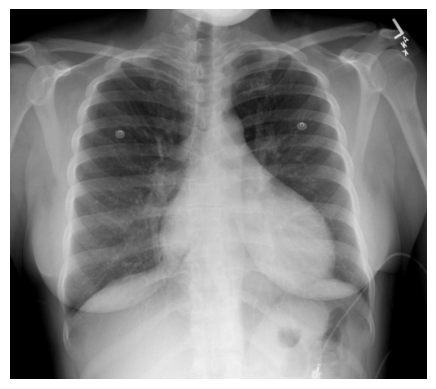

Original Report(s):
1. startseq stable enlargement of the cardiac silhouette, lateral view interlobar fissural thickening. interstitial opacities greatest in the central lungs and bases. endseq

Generated Report:
startseq the lungs are clear there is no pleural effusion or pneumothorax the heart and mediastinum are normal the skeletal structures are normal endseq


In [108]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

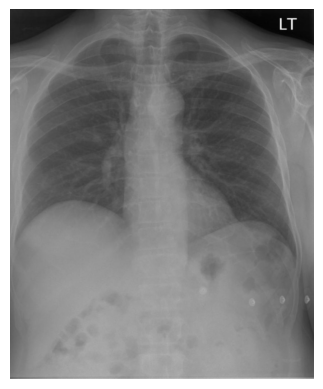

Original Report(s):
1. startseq the cardiac and mediastinal contours are within normal limits. the lungs are well-inflated and clear. there is no focal consolidation, pneumothorax, or effusion. the bony structures of the thorax are unremarkable. endseq

Generated Report:
startseq the heart is normal in size the mediastinum is unremarkable the lungs are clear endseq


In [110]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

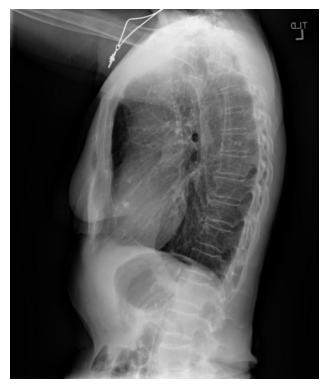

Original Report(s):
1. startseq there is some minimal biapical scarring. calcified granuloma is present in the right middle lobe. there is no pleural effusion or pneumothorax. the heart is not significantly enlarged. there are atherosclerotic changes of the aorta. arthritic changes of the skeletal structures are noted. endseq

Generated Report:
startseq the lungs are clear there is no pleural effusion or pneumothorax the heart and mediastinum are normal the skeletal structures are normal endseq


In [111]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

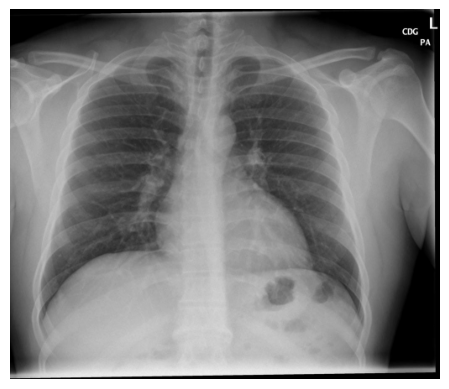

Original Report(s):
1. startseq heart size normal. lungs are clear. xxxx are normal. no pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses. endseq

Generated Report:
startseq the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax are without acute abnormality endseq


In [113]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

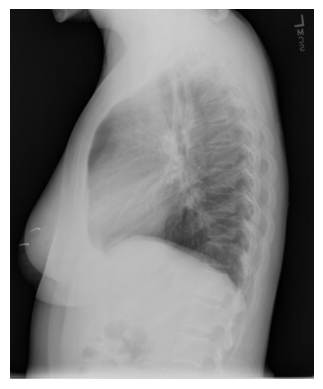

Original Report(s):
1. startseq cardiac size, mediastinal contour, and pulmonary vascularity are within normal limits. no focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. the visualized osseous structures appear intact. xxxx and curvilinear xxxx densities over the breast shadows compatible with piercings. endseq

Generated Report:
startseq the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax are without acute abnormality endseq


In [114]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

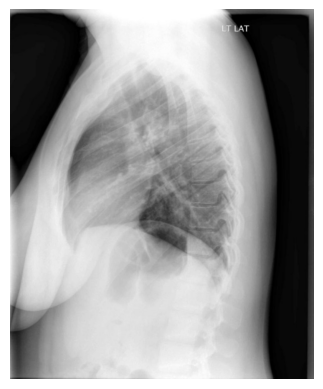

Original Report(s):
1. startseq the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion. cardiomediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality. endseq

Generated Report:
startseq the cardiomediastinal silhouette is normal in size and contour the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax no acute bony findings endseq


In [54]:
random_test_id = random.choice(test_ids)
display_image_and_reports(random_test_id, features, mapping, tokenizer, max_length)

In [115]:
precision_list = []
recall_list = []
f1_list = []

In [116]:
for image_id in tqdm(test_ids):
    # Ground truth
    ground_truth_captions = mapping[image_id]
    ground_truth = ground_truth_captions[0]  # Use the first ground truth caption

    # Predicted
    predicted_caption = predict_caption(model, features[image_id], tokenizer, max_length)

    # Tokenize
    ground_truth_tokens = ground_truth.split()
    predicted_tokens = predicted_caption.split()

    # Align token lists by padding shorter lists
    max_len = max(len(ground_truth_tokens), len(predicted_tokens))
    ground_truth_tokens.extend(['<pad>'] * (max_len - len(ground_truth_tokens)))
    predicted_tokens.extend(['<pad>'] * (max_len - len(predicted_tokens)))

    # Convert tokens to binary format for metrics
    y_true = [1 if token in ground_truth_tokens else 0 for token in predicted_tokens]
    y_pred = [1 if token in predicted_tokens else 0 for token in predicted_tokens]

    # Compute precision, recall, F1
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

  0%|          | 0/414 [00:00<?, ?it/s]

In [117]:
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)

In [118]:
print("\nEvaluation Metrics:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


Evaluation Metrics:
Average Precision: 0.3526
Average Recall: 1.0000
Average F1 Score: 0.5082
